Seleccionar solo el primer tipo de uno y el primer tipo de ceros

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, ttest_ind, mannwhitneyu

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve, accuracy_score, precision_score, recall_score, roc_curve

from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.ensemble import RUSBoostClassifier

from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import optuna
import mlflow
import pickle
import os
import joblib
import shap

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap


## Funciones

In [2]:
def convertir_a_numerico(df):

    columnas_object = df.select_dtypes(include=['object']).columns
    

    for col in columnas_object:
        try:
            df[col] = pd.to_numeric(df[col])
            print(f"Columna '{col}' convertida a tipo numérico.")
        except ValueError:
            print(f"No se pudo convertir la columna '{col}' a tipo numérico.")
    
    return df

def convertir_columnas_a_tipo(df, columnas, tipo):
    """
    Convierte las columnas especificadas de un DataFrame a un tipo de dato específico.

    Parameters:
    df (pd.DataFrame): El DataFrame a modificar.
    columnas (list): Lista de nombres de las columnas a convertir.
    tipo (str or type): El tipo de dato al que se deben convertir las columnas especificadas.

    Returns:
    pd.DataFrame: El DataFrame con las columnas especificadas convertidas.
    """
    df[columnas] = df[columnas].astype(tipo)
    return df

def plot_violin_vs_poblaciones_variable(df, poblaciones, filtro, variable):
    # Lista para almacenar los DataFrames de cada población
    dfs = []
    
    # Realizar las consultas para obtener las poblaciones
    for poblacion in poblaciones:
        cant_poblacion = df[df[filtro] == poblacion][variable]
        df_poblacion = pd.DataFrame({variable: cant_poblacion, 'Poblacion': poblacion})
        dfs.append(df_poblacion)
    
    # Combinar todos los DataFrames
    df_combined = pd.concat(dfs)
    
    # Crear el gráfico
    plt.figure(figsize=(6, 4))
    sns.violinplot(x='Poblacion', y=variable, data=df_combined)
    plt.title('Comportamiento de la variable {variable}'.format(variable=variable))
    plt.xlabel('Población')
    plt.ylabel('Cantidad de {variable}'.format(variable=variable))
    plt.show()

def plot_densidad_vs_poblaciones_variable(df, poblaciones, filtro, variable):
    # Lista para almacenar los DataFrames de cada población
    dfs = []
    
    # Realizar las consultas para obtener las poblaciones
    for poblacion in poblaciones:
        cant_poblacion = df[df[filtro] == poblacion][variable]
        df_poblacion = pd.DataFrame({variable: cant_poblacion, 'Poblacion': poblacion})
        dfs.append(df_poblacion)
    
    # Combinar todos los DataFrames
    df_combined = pd.concat(dfs)
    
    # Crear el gráfico
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df_combined, x=variable, hue='Poblacion', fill=True,common_norm=False)
    plt.title('Comportamiento de la variable {variable}'.format(variable=variable))
    plt.xlabel('Población')
    plt.ylabel('Cantidad de {variable}'.format(variable=variable))
    plt.show()

def calidad_none(df):
    # Reemplazar 'None' (cadena) con NaN
    df_replaced = df.replace('None', np.nan)
    
    # Contar valores nulos (NaN) en cada columna
    none_counts = df_replaced.isna().sum()
    
    # Crear un DataFrame con los resultados
    result = pd.DataFrame({'Column': none_counts.index, 
                           'None_Count': none_counts.values,
                           'None_Percentage': none_counts.values / len(df) })
    
    return result

# Calculo de metricas
print("Calculo de metricas")
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return accuracy, precision, recall, f1, specificity, tn, fp, fn, tp

# def save_confusion_matrix(cm, title):
#     plt.figure(figsize=(5, 3.5))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
#     plt.title(title)
#     plt.xlabel('Predicted')
#     plt.ylabel('Actual')
#     cm_filename = '{title}.png'.format(title)
#     plt.savefig(cm_filename)
#     plt.close()
#     return cm_filename

# Optimizar modelo
def optimize_with_optuna_mlflow(X_train, y_train, X_val, y_val, X_test, y_test,
                                 n_trials=30, tecnica_submuestreo='None',
                                 experiment_name=None,model_type='catboost'):

    # Crear un nuevo experimento
    try:
        experiment_id = mlflow.create_experiment(experiment_name)
    except mlflow.exceptions.MlflowException as e:
        print(f"No se pudo crear el experimento. Error: {e}")
        experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
    
    # Establecer el experimento activo   
    mlflow.set_experiment(experiment_name)
    
    best_model = None
    best_score = 0

    def get_model_params(trial):
        if model_type == 'xgboost':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'random_state': 42
            }
            return XGBClassifier(**params)
        
        elif model_type == 'lgbm':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'num_leaves': trial.suggest_int('num_leaves', 31, 128),
                'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'is_unbalance':True,
                'random_state': 42
            }
            return LGBMClassifier(**params)
        
        elif model_type == 'catboost':
            params = {
                'iterations': trial.suggest_int('iterations', 100, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'depth': trial.suggest_int('depth', 4, 10),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
                'border_count': trial.suggest_int('border_count', 200, 300),
                'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
                'random_seed': 42,
                'auto_class_weights': 'Balanced'
            }
            return CatBoostClassifier(**params)
        elif model_type == 'rusboost':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'random_state': 42
            }
            
            return RUSBoostClassifier(**params)
        
        else:
            raise ValueError("Model type not supported")

    def objective(trial):
        nonlocal best_model
        nonlocal best_score

        model = get_model_params(trial)

        if model_type == 'catboost':
            model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=100, verbose=False)
        elif model_type== 'xgboost':
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)
        elif model_type == 'lgbm':
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
        else:
            model.fit(X_train, y_train)

        y_pred_train = model.predict(X_train) 
        accuracy_train, precision_train, recall_train, f1_train, specificity_train, tn_train, fp_train, fn_train, tp_train = calculate_metrics(y_train, y_pred_train)   

        y_pred_val = model.predict(X_val)
        accuracy, precision, recall, f1, specificity, tn, fp, fn, tp = calculate_metrics(y_val, y_pred_val)

        y_pred_test = model.predict(X_test)
        accuracy_test, precision_test, recall_test, f1_test, specificity_test, tn_test, fp_test, fn_test, tp_test = calculate_metrics(y_test, y_pred_test)
    

        if f1 > best_score:
            best_score = f1
            best_model = model

        # train_cm = confusion_matrix(y_train, y_pred_train)
        # val_cm = confusion_matrix(y_val, y_pred_val)
        # test_cm = confusion_matrix(y_test, y_pred_test)

        # cm_filename=save_confusion_matrix(val_cm, 'Confusion Matrix - Validation Set')


        with mlflow.start_run(experiment_id=experiment_id):
            mlflow.set_tag('tecnica_submuestreo', tecnica_submuestreo)
            mlflow.set_tag('model_type', model_type)

            mlflow.log_params(model.get_params())

            mlflow.log_metric('f1', f1)
            mlflow.log_metric('precision', precision)
            mlflow.log_metric('recall', recall)
            mlflow.log_metric('accuracy', accuracy)
            mlflow.log_metric('specificity', specificity)
            mlflow.log_metric('tn', tn)
            mlflow.log_metric('fp', fp)
            mlflow.log_metric('fn', fn)
            mlflow.log_metric('tp', tp)

            mlflow.log_metric('f1_test', f1_test)
            mlflow.log_metric('precision_test', precision_test)
            mlflow.log_metric('recall_test', recall_test)
            mlflow.log_metric('accuracy_test', accuracy_test)
            mlflow.log_metric('specificity_test', specificity_test)
            mlflow.log_metric('tn_test', tn_test)
            mlflow.log_metric('fp_test', fp_test)
            mlflow.log_metric('fn_test', fn_test)
            mlflow.log_metric('tp_test', tp_test)

            mlflow.log_metric('f1_train', f1_train)
            mlflow.log_metric('precision_train', precision_train)
            mlflow.log_metric('recall_train', recall_train)
            mlflow.log_metric('accuracy_train', accuracy_train)
            mlflow.log_metric('specificity_train', specificity_train)
            mlflow.log_metric('tn_train', tn_train)
            mlflow.log_metric('fp_train', fp_train)
            mlflow.log_metric('fn_train', fn_train)
            mlflow.log_metric('tp_train', tp_train)

            # mlflow.log_artifact(cm_filename)


            # Guardar el modelo como archivo .pkl con el nombre del experimento
            model_filename = f'{experiment_name}.pkl'
            with open(model_filename, 'wb') as f:
                pickle.dump(model, f)
            mlflow.log_artifact(model_filename)

        return f1

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    print('Best hyperparameters: ', study.best_params)
    # optimal_threshold = study.best_params['threshold']

    # return best_model,optimal_threshold
    return best_model


# Tratamiento conjunto desbalanceado
print("Tratamiento conjunto desbalanceado")

def balance_data(X_train, y_train, tecnica_submuestreo):
    if tecnica_submuestreo == 'RandomUnderSampler':
        rus = RandomUnderSampler(sampling_strategy=1, random_state=42)
        X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
    elif tecnica_submuestreo == 'tomeklinks':
        tomek_links = TomekLinks(sampling_strategy='majority') 
        X_train_resampled, y_train_resampled = tomek_links.fit_resample(X_train, y_train)
    else:
        raise ValueError(f"Metodo {tecnica_submuestreo} no soportada")
    return X_train_resampled, y_train_resampled


    
# Función para predecir
print("Predecir")
def predict(model, X, threshold=0.5):
    y_pred_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_pred_proba > threshold).astype(int)
    return y_pred

# Función para consolidar resultados
print("Consolidar resultados")
def consolidate_results(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test, tecnica_submuestreo, model_name):
    results = {
        'tecnica_submuestreo': [tecnica_submuestreo] * 3,
        'tecnica_ml': [model_name] * 3,
        'dataset': ['Train', 'Validation', 'Test'],
        'accuracy': [accuracy_score(y_train, y_pred_train), accuracy_score(y_val, y_pred_val), accuracy_score(y_test, y_pred_test)],
        'precision': [precision_score(y_train, y_pred_train), precision_score(y_val, y_pred_val), precision_score(y_test, y_pred_test)],
        'recall': [recall_score(y_train, y_pred_train), recall_score(y_val, y_pred_val), recall_score(y_test, y_pred_test)],
        'specificity': [
            calculate_metrics(y_train, y_pred_train)[4],
            calculate_metrics(y_val, y_pred_val)[4],
            calculate_metrics(y_test, y_pred_test)[4]
        ],
        'f1_score': [f1_score(y_train, y_pred_train), f1_score(y_val, y_pred_val), f1_score(y_test, y_pred_test)],
        'tn': [calculate_metrics(y_train, y_pred_train)[5], calculate_metrics(y_val, y_pred_val)[5], calculate_metrics(y_test, y_pred_test)[5]],
        'fp': [calculate_metrics(y_train, y_pred_train)[6], calculate_metrics(y_val, y_pred_val)[6], calculate_metrics(y_test, y_pred_test)[6]],
        'fn': [calculate_metrics(y_train, y_pred_train)[7], calculate_metrics(y_val, y_pred_val)[7], calculate_metrics(y_test, y_pred_test)[7]],
        'tp': [calculate_metrics(y_train, y_pred_train)[8], calculate_metrics(y_val, y_pred_val)[8], calculate_metrics(y_test, y_pred_test)[8]]
    }
    return pd.DataFrame(results)


def control_outliers(dataframe):
    var = []
    for column in dataframe.columns:
        if dataframe[column].dtype == float:
            var.append(column)
    
    for column in var:
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
    
        umbral_superior = Q3 + 1.5 * IQR
        umbral_inferior = Q1 - 1.5 * IQR
    
        dataframe[column] = dataframe[column].clip(lower=umbral_inferior, upper=umbral_superior)
    
    return dataframe



Calculo de metricas
Tratamiento conjunto desbalanceado
Predecir
Consolidar resultados


In [4]:
df_var_rpta_ppal_feature = pd.read_csv('prueba_op_base_pivot_var_rpta_alt_enmascarado_trtest.csv')

df_var_rpta_ppal_feature["llave_modelo"] = df_var_rpta_ppal_feature["nit_enmascarado"].astype(str) + \
                                                    "#" + df_var_rpta_ppal_feature["num_oblig_orig_enmascarado"].astype(str) + \
                                                    "#" + df_var_rpta_ppal_feature["num_oblig_enmascarado"].astype(str)

df_var_rpta_ppal_feature["llave_modelo_2"] = df_var_rpta_ppal_feature["nit_enmascarado"].astype(str) + \
                                                    "#" + df_var_rpta_ppal_feature["num_oblig_orig_enmascarado"].astype(str) 
df_var_rpta_ppal_feature.drop(['alternativa_aplicada_agr','marca_agrupada_rgo'
                                                          ,'alter_posible3_2','alter_posible2_2','porc_pago_mes'
                                                          ], axis=1,inplace=True)
df_var_rpta_ppal_feature = df_var_rpta_ppal_feature.replace('None', np.nan)
df_var_rpta_ppal_feature = df_var_rpta_ppal_feature.dropna()
df_var_rpta_ppal_feature = convertir_columnas_a_tipo(df_var_rpta_ppal_feature, 
                                                     ['cant_gestiones','rpc','cant_acuerdo'],int)

df_var_rpta_ppal_feature = convertir_columnas_a_tipo(df_var_rpta_ppal_feature, 
                                                     ['valor_cuota_mes','pago_cuota'],float)

df_op_base_pivot_var_rpta_v1 = df_var_rpta_ppal_feature[[
    'llave_modelo'
    ,'llave_modelo_2'
    ,'fecha_var_rpta_alt'
    ,'var_rpta_alt'
    ,'tipo_var_rpta_alt'
    ,'banca'
    ,'segmento'
    ,'producto'
    ,'producto_cons'
    ,'min_mora'
    ,'max_mora'
    , 'dias_mora_fin'
    ,'vlr_vencido'
    ,'saldo_capital'
    ,'endeudamiento'
    , 'cant_gestiones'
    , 'cant_gestiones_binario'
    , 'rpc'
    , 'promesas_cumplidas'
    , 'cant_promesas_cumplidas_binario'
    , 'cant_acuerdo'
    , 'cant_acuerdo_binario'
    , 'descripcion_ranking_mejor_ult'
    , 'descripcion_ranking_post_ult'
    , 'marca_alt_rank'
    , 'marca_alt_apli'
    , 'valor_cuota_mes'
    , 'pago_cuota'
    , 'porc_pago_cuota'
    , 'pago_mes'
    , 'pagos_tanque'
]]

df_op_base_pivot_var_rpta_v1.shape

productos = {
    'TARJETA DE CREDITO': 'tiene_tdc',
    'LIBRE INVERSION': 'tiene_libr_inv',
    'CARTERA ORDINARIA': 'tiene_cart_ordinaria',
    'HIPOTECARIO VIVIENDA': 'tiene_hipo',
    'LIBRANZA': 'tiene_libranza',
    'ROTATIVOS' : 'tiene_rot'
}

for producto, columna in productos.items():
    df_op_base_pivot_var_rpta_v1[columna] = (df_op_base_pivot_var_rpta_v1['producto'] == producto).astype(int)

df_op_base_pivot_var_rpta_v1['tiene_otros_productos'] = (~df_op_base_pivot_var_rpta_v1['producto'].isin(productos.keys())).astype(int)

descripcion_ranking_mejor_ult = {
    'PLAN DE PAGO ': 'ranking_plan_pago',
    'ACEPTA ALTERNATIVA': 'ranking_acepta_alternativa',
    'NO ACEPTA ACUERDO': 'ranking_no_acepta_acuerdo',
    'PLAN DE COMPROMISO CUMPLIDO': 'ranking_plan_compromiso_cumplido',
    'INTERESADO ALTERNATIVA': 'ranking_int_alternativa'
}

# Filtrar el DataFrame
df_op_base_pivot_var_rpta_v1_filtered = df_op_base_pivot_var_rpta_v1[
    (df_op_base_pivot_var_rpta_v1['tipo_var_rpta_alt'].isin(['a_uno_tipo_1', 'd_cero_tipo_1'])) &
    (df_op_base_pivot_var_rpta_v1['banca'] == 'Banca Personas')
]

# Mostrar el DataFrame filtrado
df_op_base_pivot_var_rpta_v1_filtered.shape

df_op_base_pivot_var_rpta_v1_filtered['pagos_tanque'] = df_op_base_pivot_var_rpta_v1_filtered['pagos_tanque'].replace({'Sin pago': 0, 'Con pago': 1})

df_op_base_pivot_var_rpta_v2=df_op_base_pivot_var_rpta_v1_filtered.drop(['producto','banca',
                            'segmento',
                            'producto_cons','descripcion_ranking_mejor_ult',
                            'descripcion_ranking_post_ult','marca_alt_rank','marca_alt_apli'], axis=1)
df_op_base_pivot_var_rpta_v2.info()

df_op_base_pivot_var_rpta_v2['fecha_corte']=df_op_base_pivot_var_rpta_v2['fecha_var_rpta_alt']-1

df_op_base_pivot_var_rpta_v2.to_csv('df_op_base_pivot_var_rpta_v3.csv', index=False)




C:\Users\davzapat\AppData\Local\Temp\ipykernel_15228\3896374800.py:1: DtypeWarning: Columns (28,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df_var_rpta_ppal_feature = pd.read_csv('prueba_op_base_pivot_var_rpta_alt_enmascarado_trtest.csv')
C:\Users\davzapat\AppData\Local\Temp\ipykernel_15228\3896374800.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_op_base_pivot_var_rpta_v1[columna] = (df_op_base_pivot_var_rpta_v1['producto'] == producto).astype(int)
C:\Users\davzapat\AppData\Local\Temp\ipykernel_15228\3896374800.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173893 entries, 0 to 568239
Data columns (total 30 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   llave_modelo                     173893 non-null  object 
 1   llave_modelo_2                   173893 non-null  object 
 2   fecha_var_rpta_alt               173893 non-null  int64  
 3   var_rpta_alt                     173893 non-null  int64  
 4   tipo_var_rpta_alt                173893 non-null  object 
 5   min_mora                         173893 non-null  int64  
 6   max_mora                         173893 non-null  int64  
 7   dias_mora_fin                    173893 non-null  int64  
 8   vlr_vencido                      173893 non-null  float64
 9   saldo_capital                    173893 non-null  float64
 10  endeudamiento                    173893 non-null  float64
 11  cant_gestiones                   173893 non-null  int32  
 12  ca

In [5]:
df_var_rpta_ppal_feature['tipo_var_rpta_alt'].unique()

array(['a_uno_tipo_1', 'b_uno_tipo_2', 'e_cero_tipo_2', 'c_uno_tipo_3',
       'd_cero_tipo_1'], dtype=object)

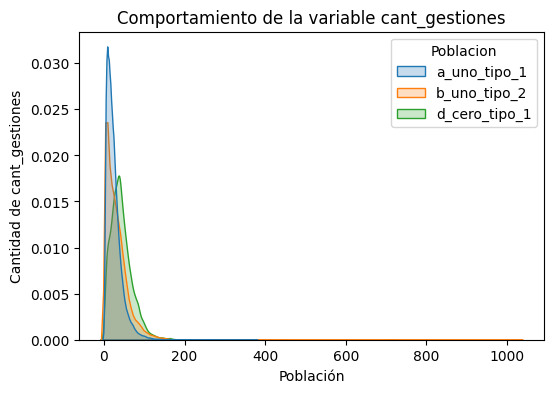

In [6]:
plot_densidad_vs_poblaciones_variable(df_var_rpta_ppal_feature, ['a_uno_tipo_1', 'b_uno_tipo_2','d_cero_tipo_1'], 'tipo_var_rpta_alt', 'cant_gestiones')

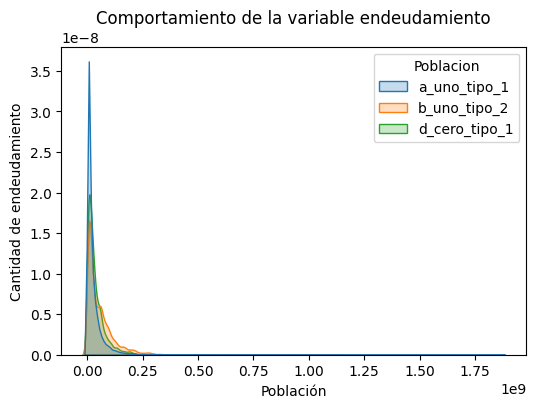

In [7]:
plot_densidad_vs_poblaciones_variable(df_var_rpta_ppal_feature, ['a_uno_tipo_1', 'b_uno_tipo_2','d_cero_tipo_1'], 'tipo_var_rpta_alt', 'endeudamiento')

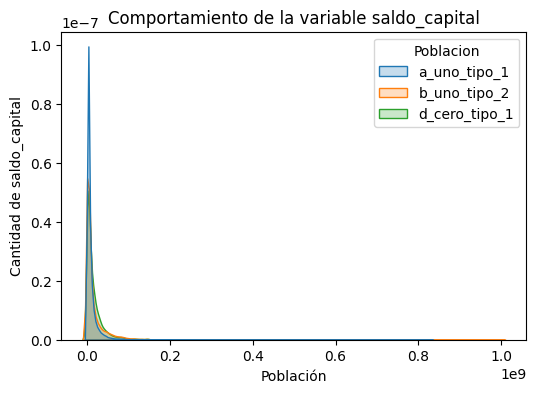

In [8]:
plot_densidad_vs_poblaciones_variable(df_var_rpta_ppal_feature, ['a_uno_tipo_1', 'b_uno_tipo_2','d_cero_tipo_1'], 'tipo_var_rpta_alt', 'saldo_capital')

In [9]:
variables = [
    'max_mora', 'dias_mora_fin', 'vlr_vencido', 'saldo_capital', 'endeudamiento',
    'cant_alter_posibles', 'cant_gestiones', 'cant_gestiones_binario', 'rpc', 
    'promesas_cumplidas', 'cant_promesas_cumplidas_binario', 'cant_acuerdo', 
    'cant_acuerdo_binario', 'valor_cuota_mes', 'pago_cuota', 'porc_pago_cuota', 'pago_mes',"tipo_var_rpta_alt"
]
df_var_interes=df_var_rpta_ppal_feature[variables]

In [10]:
df_var_interes_clases = df_var_interes[df_var_interes['tipo_var_rpta_alt'].isin(['a_uno_tipo_1', 'b_uno_tipo_2','d_cero_tipo_1'])]

In [11]:
op_data = df_var_interes_clases[
    [
    'max_mora',
    'dias_mora_fin',
    'vlr_vencido',
    'saldo_capital',
    'endeudamiento',
    'cant_alter_posibles',
    'cant_gestiones',
    'cant_gestiones_binario',
    'rpc',
    'promesas_cumplidas',
    'cant_promesas_cumplidas_binario',
    'cant_acuerdo',
    'cant_acuerdo_binario',
    'valor_cuota_mes',
    'pago_cuota',
    'porc_pago_cuota',
    'pago_mes'
]
].values
scaled_op_data = StandardScaler().fit_transform(op_data)

In [12]:
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
reducer = umap.UMAP()
embedding_clase0 = reducer.fit_transform(scaled_op_data)
embedding_clase0.shape

(259564, 2)

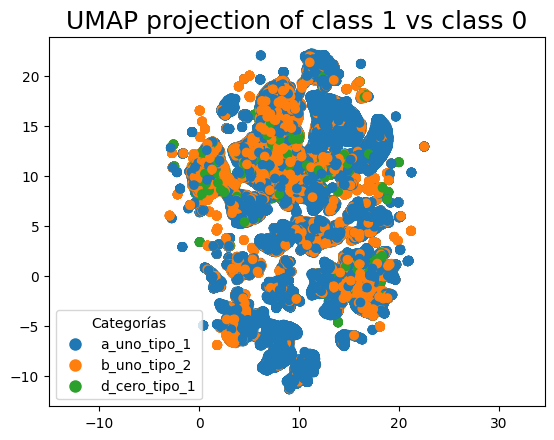

In [13]:
# Definir el mapeo de categorías a índices
category_mapping = {"a_uno_tipo_1": 0, "b_uno_tipo_2": 1, "d_cero_tipo_1": 2}

# Obtener los colores para cada categoría
colors = [sns.color_palette()[x] for x in df_var_interes_clases.tipo_var_rpta_alt.map(category_mapping)]

# Crear el scatter plot
plt.scatter(embedding_clase0[:, 0], embedding_clase0[:, 1], c=colors)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of class 1 vs class 0', fontsize=18)

# Crear la leyenda
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=sns.color_palette()[i], markersize=10) for i in range(len(category_mapping))]
labels = list(category_mapping.keys())
plt.legend(handles, labels, title="Categorías")

# Mostrar el gráfico
plt.show()

En el gráfico se puede apreciar que donde se encuentran los puntos naranjados (b_uno_tipo_2) por lo general estan los verdes (d_cero_tipo_1), con lo que podriamos concluir que estas clases suelen tener comportamientos similares, y que para un posterior modelado predictivo podria generar ruido incluir en la clase 1 los b_uno_tipo_2

# Construcción de Base de Modelado

## Base a Modelar

In [3]:
df_op_base_pivot_var_rpta = pd.read_csv('df_op_base_pivot_var_rpta_v3.csv')
df_var_prob_mod_cobranza = pd.read_csv('df_var_prob_mod_cobranza_v2.csv')
df_master_customer = pd.read_csv('df_master_customer_v2.csv')
df_comportamieto_pagos = pd.read_csv(r'C:\Users\davzapat\Documents\Personal\Reto  Kaggle\df_comportamiento_pagos_v2.csv')

In [4]:
df_op_base_pivot_var_rpta = df_op_base_pivot_var_rpta.sort_values(by='fecha_var_rpta_alt')
df_op_base_pivot_var_rpta_v1 = df_op_base_pivot_var_rpta.drop(columns=['tipo_var_rpta_alt'])
df_op_base_pivot_var_rpta_v1['llave_modelo3'] = df_op_base_pivot_var_rpta_v1['llave_modelo'].apply(lambda x: f"{x.split('#')[0]}#{x.split('#')[-1]}")
df_op_base_pivot_var_rpta_v2 = df_op_base_pivot_var_rpta_v1[[
    'llave_modelo',
    'llave_modelo_2',
    'llave_modelo3',
    'fecha_corte',
    'var_rpta_alt'
]]
df_op_base_pivot_var_rpta_v2.head()

,llave_modelo,llave_modelo_2,llave_modelo3,fecha_corte,var_rpta_alt
0,630611#219718#863073,630611#219718,630611#863073,202307,1
78663,463901#422341#657646,463901#422341,463901#657646,202307,1
78664,449012#453439#626903,449012#453439,449012#626903,202307,1
78667,278516#494637#585705,278516#494637,278516#585705,202307,1
78673,587662#893392#186950,587662#893392,587662#186950,202307,1


Prob_Cobranza

In [5]:
df_var_prob_mod_cobranza=df_var_prob_mod_cobranza.fillna(0)
df_var_prob_mod_cobranza_v1 = df_var_prob_mod_cobranza[[
    'llave_modelo_2'
    , 'fecha_corte'
    , 'lote'
    , 'prob_propension'
    , 'prob_alrt_temprana'
    , 'prob_auto_cura'
    , 'lote_n-1'
    , 'prob_propension_n-1'
    , 'prob_alrt_temprana_n-1'
    , 'prob_auto_cura_n-1'
    , 'lote_n-2'
    , 'prob_propension_n-2'
    , 'prob_alrt_temprana_n-2'
    , 'prob_auto_cura_n-2'
    , 'lote_n-3'
    , 'prob_propension_n-3'
    , 'prob_alrt_temprana_n-3'
    , 'prob_auto_cura_n-3'
    , 'lote_n-4'
    , 'prob_propension_n-4'
    , 'prob_alrt_temprana_n-4'
    , 'prob_auto_cura_n-4'
    , 'lote_n-5'
    , 'prob_propension_n-5'
    , 'prob_alrt_temprana_n-5'
    , 'prob_auto_cura_n-5'
    , 'lote_n-6'
    , 'prob_propension_n-6'
    , 'prob_alrt_temprana_n-6'
    , 'prob_auto_cura_n-6'
    
]]
merged_df_v1= pd.merge(df_op_base_pivot_var_rpta_v2, 
                     df_var_prob_mod_cobranza_v1, 
                     left_on=['llave_modelo3', 'fecha_corte'], 
                     right_on=['llave_modelo_2', 'fecha_corte'], 
                     how='left')  # tipos 'left', 'right' o 'outer' 

merged_df_v1.head()

,llave_modelo,llave_modelo_2_x,llave_modelo3,fecha_corte,var_rpta_alt,llave_modelo_2_y,lote,prob_propension,prob_alrt_temprana,prob_auto_cura,...,prob_alrt_temprana_n-4,prob_auto_cura_n-4,lote_n-5,prob_propension_n-5,prob_alrt_temprana_n-5,prob_auto_cura_n-5,lote_n-6,prob_propension_n-6,prob_alrt_temprana_n-6,prob_auto_cura_n-6
0,630611#219718#863073,630611#219718,630611#863073,202307,1,630611#863073,1.0,0.654196,0.487352,0.227337,...,0.473203,0.379341,1.0,0.835031,0.266729,0.810193,1.0,0.835059,0.204160,0.825482
1,463901#422341#657646,463901#422341,463901#657646,202307,1,463901#657646,1.0,0.393548,0.565148,0.196722,...,0.614206,0.343136,1.0,0.811077,0.591832,0.324689,1.0,0.817247,0.525345,0.301849
2,449012#453439#626903,449012#453439,449012#626903,202307,1,449012#626903,1.0,0.739650,0.524968,0.297645,...,0.072515,0.769169,3.0,0.815926,0.078512,0.721646,0.0,0.000000,0.000000,0.000000
3,278516#494637#585705,278516#494637,278516#585705,202307,1,278516#585705,2.0,0.905667,0.476934,0.678206,...,0.238203,0.870264,2.0,0.863465,0.123427,0.867382,2.0,0.912783,0.096658,0.844766
4,587662#893392#186950,587662#893392,587662#186950,202307,1,587662#186950,2.0,0.571380,0.709135,0.281844,...,0.591762,0.422470,2.0,0.806465,0.514587,0.743062,2.0,0.808927,0.131923,0.733138


In [6]:
merged_df_v1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173893 entries, 0 to 173892
Data columns (total 34 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   llave_modelo            173893 non-null  object 
 1   llave_modelo_2_x        173893 non-null  object 
 2   llave_modelo3           173893 non-null  object 
 3   fecha_corte             173893 non-null  int64  
 4   var_rpta_alt            173893 non-null  int64  
 5   llave_modelo_2_y        173597 non-null  object 
 6   lote                    173597 non-null  float64
 7   prob_propension         173597 non-null  float64
 8   prob_alrt_temprana      173597 non-null  float64
 9   prob_auto_cura          173597 non-null  float64
 10  lote_n-1                173597 non-null  float64
 11  prob_propension_n-1     173597 non-null  float64
 12  prob_alrt_temprana_n-1  173597 non-null  float64
 13  prob_auto_cura_n-1      173597 non-null  float64
 14  lote_n-2            

In [7]:
merged_df_v1['nit_enmascarado'] = merged_df_v1['llave_modelo'].apply(lambda x: x.split('#')[0])
merged_df_v1['nit_enmascarado']=merged_df_v1['nit_enmascarado'].astype(str)

Comportamientos de pagos

In [8]:
merged_df_v2= pd.merge(merged_df_v1, 
                     df_comportamieto_pagos, 
                     left_on=['llave_modelo3', 'fecha_corte'], 
                     right_on=['llave_modelo_2', 'fecha_corte'], 
                     how='left')  
merged_df_v2.head()

,llave_modelo,llave_modelo_2_x,llave_modelo3,fecha_corte,var_rpta_alt,llave_modelo_2_y,lote,prob_propension,prob_alrt_temprana,prob_auto_cura,...,porc_pago_n-4,diferencia_dias_n-4,valor_cuota_mes_n-5,pago_total_n-5,porc_pago_n-5,diferencia_dias_n-5,valor_cuota_mes_n-6,pago_total_n-6,porc_pago_n-6,diferencia_dias_n-6
0,630611#219718#863073,630611#219718,630611#863073,202307,1,630611#863073,1.0,0.654196,0.487352,0.227337,...,0.0,0.0,496815.0,0.0,0.0,0.0,538113.0,1614342.0,300.0,0.0
1,463901#422341#657646,463901#422341,463901#657646,202307,1,463901#657646,1.0,0.393548,0.565148,0.196722,...,15.0,0.0,1601958.0,4563385.0,285.0,20.0,857316.0,57195.0,7.0,0.0
2,449012#453439#626903,449012#453439,449012#626903,202307,1,449012#626903,1.0,0.739650,0.524968,0.297645,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,278516#494637#585705,278516#494637,278516#585705,202307,1,278516#585705,2.0,0.905667,0.476934,0.678206,...,200.0,0.0,31645.0,126568.0,400.0,29.0,31637.0,31645.0,100.0,0.0
4,587662#893392#186950,587662#893392,587662#186950,202307,1,587662#186950,2.0,0.571380,0.709135,0.281844,...,1736.0,25.0,110788.0,522617.0,472.0,26.0,110788.0,11122.0,10.0,0.0


In [9]:
calidad_none(merged_df_v2)

,Column,None_Count,None_Percentage
0,llave_modelo,0,0.000000
1,llave_modelo_2_x,0,0.000000
2,llave_modelo3,0,0.000000
3,fecha_corte,0,0.000000
4,var_rpta_alt,0,0.000000
...,...,...,...
75,diferencia_dias_n-5,188,0.001081
76,valor_cuota_mes_n-6,188,0.001081
77,pago_total_n-6,188,0.001081
78,porc_pago_n-6,188,0.001081


In [10]:
base_modelado_df= merged_df_v2[[
'llave_modelo'
,'llave_modelo3'
,'fecha_corte'
,'var_rpta_alt'
,'lote'
,'prob_propension'
,'prob_alrt_temprana'
,'prob_auto_cura'
,'lote_n-1'
,'prob_propension_n-1'
,'prob_alrt_temprana_n-1'
,'prob_auto_cura_n-1'
,'lote_n-2'
,'prob_propension_n-2'
,'prob_alrt_temprana_n-2'
,'prob_auto_cura_n-2'
,'lote_n-3'
,'prob_propension_n-3'
,'prob_alrt_temprana_n-3'
,'prob_auto_cura_n-3'
,'lote_n-4'
,'prob_propension_n-4'
,'prob_alrt_temprana_n-4'
,'prob_auto_cura_n-4'
,'lote_n-5'
,'prob_propension_n-5'
,'prob_alrt_temprana_n-5'
,'prob_auto_cura_n-5'
,'lote_n-6'
,'prob_propension_n-6'
,'prob_alrt_temprana_n-6'
,'prob_auto_cura_n-6'
,'valor_cuota_mes'
,'pago_total'
,'porc_pago'
,'tiene_cuota_tdc'
,'tiene_cuota_libr_inv'
,'tiene_cuota_rot'
,'tiene_cuota_cart_ordinaria'
,'tiene_cuota_hipo'
,'tiene_cuota_libranza'
,'diferencia_dias'
,'marca_pago_mas'
,'marca_pago_menos'
,'marca_pago_igual'
,'marca_no_pago'
,'marca_facturacion_mes_sgte'
,'marca_cancelado'
,'marca_ajustes_banco'
,'ajustes_banco_no'
,'ajustes_banco_rediferidos'
,'ajustes_banco_ajustes'
,'valor_cuota_mes_n-1'
,'pago_total_n-1'
,'porc_pago_n-1'
,'diferencia_dias_n-1'
,'valor_cuota_mes_n-2'
,'pago_total_n-2'
,'porc_pago_n-2'
,'diferencia_dias_n-2'
,'valor_cuota_mes_n-3'
,'pago_total_n-3'
,'porc_pago_n-3'
,'diferencia_dias_n-3'
,'valor_cuota_mes_n-4'
,'pago_total_n-4'
,'porc_pago_n-4'
,'diferencia_dias_n-4'
,'valor_cuota_mes_n-5'
,'pago_total_n-5'
,'porc_pago_n-5'
,'diferencia_dias_n-5'
,'valor_cuota_mes_n-6'
,'pago_total_n-6'
,'porc_pago_n-6'
,'diferencia_dias_n-6'
]]

base_modelado_df.head()

,llave_modelo,llave_modelo3,fecha_corte,var_rpta_alt,lote,prob_propension,prob_alrt_temprana,prob_auto_cura,lote_n-1,prob_propension_n-1,...,porc_pago_n-4,diferencia_dias_n-4,valor_cuota_mes_n-5,pago_total_n-5,porc_pago_n-5,diferencia_dias_n-5,valor_cuota_mes_n-6,pago_total_n-6,porc_pago_n-6,diferencia_dias_n-6
0,630611#219718#863073,630611#863073,202307,1,1.0,0.654196,0.487352,0.227337,1.0,0.611498,...,0.0,0.0,496815.0,0.0,0.0,0.0,538113.0,1614342.0,300.0,0.0
1,463901#422341#657646,463901#657646,202307,1,1.0,0.393548,0.565148,0.196722,1.0,0.339501,...,15.0,0.0,1601958.0,4563385.0,285.0,20.0,857316.0,57195.0,7.0,0.0
2,449012#453439#626903,449012#626903,202307,1,1.0,0.739650,0.524968,0.297645,1.0,0.748556,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,278516#494637#585705,278516#585705,202307,1,2.0,0.905667,0.476934,0.678206,2.0,0.902082,...,200.0,0.0,31645.0,126568.0,400.0,29.0,31637.0,31645.0,100.0,0.0
4,587662#893392#186950,587662#186950,202307,1,2.0,0.571380,0.709135,0.281844,2.0,0.754426,...,1736.0,25.0,110788.0,522617.0,472.0,26.0,110788.0,11122.0,10.0,0.0


In [11]:
base_modelado_df = base_modelado_df.fillna(0)

In [12]:
base_modelado_df.shape

(173894, 76)

In [13]:
base_modelado_df.fecha_corte.unique()

array([202307, 202308, 202309, 202310, 202311], dtype=int64)

In [14]:
muestra_train_val = base_modelado_df[base_modelado_df['fecha_corte'] != 202312]

# Entrenamiento

## Predictores Débiles

### Iter 1

In [39]:
from sklearn.utils import resample
df = muestra_train_val

# Definir las variables
features = [ 'lote' ,'prob_propension' ,'prob_alrt_temprana' ,'prob_auto_cura' ,'lote_n-1' ,
            'prob_propension_n-1' ,'prob_alrt_temprana_n-1' ,'prob_auto_cura_n-1' ,'lote_n-2' ,
            'prob_propension_n-2' ,'prob_alrt_temprana_n-2' ,'prob_auto_cura_n-2' ,'lote_n-3' ,
            'prob_propension_n-3' ,'prob_alrt_temprana_n-3' ,'prob_auto_cura_n-3' ,'lote_n-4' ,
            'prob_propension_n-4' ,'prob_alrt_temprana_n-4' ,'prob_auto_cura_n-4' ,'lote_n-5' ,
            'prob_propension_n-5' ,'prob_alrt_temprana_n-5' ,'prob_auto_cura_n-5' ,'lote_n-6' ,
            'prob_propension_n-6' ,'prob_alrt_temprana_n-6' ,'prob_auto_cura_n-6' ,'valor_cuota_mes' ,
            'pago_total' ,'porc_pago' ,'tiene_cuota_tdc' ,'tiene_cuota_libr_inv' ,'tiene_cuota_rot' ,
            'tiene_cuota_cart_ordinaria' ,'tiene_cuota_hipo' ,'tiene_cuota_libranza' ,'diferencia_dias' ,
            'marca_pago_mas' ,'marca_pago_menos' ,'marca_pago_igual' ,'marca_no_pago' ,'marca_facturacion_mes_sgte' 
            ,'marca_cancelado' ,'marca_ajustes_banco' ,'ajustes_banco_no' ,'ajustes_banco_rediferidos' 
            ,'ajustes_banco_ajustes' ,'valor_cuota_mes_n-1' ,'pago_total_n-1' ,'porc_pago_n-1' 
            ,'diferencia_dias_n-1' ,'valor_cuota_mes_n-2' ,'pago_total_n-2' ,'porc_pago_n-2' ,
            'diferencia_dias_n-2' ,'valor_cuota_mes_n-3' ,'pago_total_n-3' ,'porc_pago_n-3' ,'diferencia_dias_n-3' ,
            'valor_cuota_mes_n-4' ,'pago_total_n-4' ,'porc_pago_n-4' ,'diferencia_dias_n-4' ,'valor_cuota_mes_n-5' ,'pago_total_n-5' ,
            'porc_pago_n-5' ,'diferencia_dias_n-5' ,'valor_cuota_mes_n-6' ,'pago_total_n-6' ,'porc_pago_n-6' ,'diferencia_dias_n-6' ]

target = 'var_rpta_alt'

# Crear conjuntos de entrenamiento y validación
train_df = df[df['fecha_corte'] < 202311]  # Ajusta la fecha según tus datos
val_df = df[df['fecha_corte'] >= 202311]  # Ajusta la fecha según tus datos

# Under-sampling de la clase mayoritaria en el conjunto de entrenamiento
df_majority = train_df[train_df[target] == 1]
df_minority = train_df[train_df[target] == 0]

df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority),     # to match minority class
                                   random_state=42)  # reproducible results

train_df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Separar características y objetivo
X_train = train_df_downsampled[features]
y_train = train_df_downsampled[target]
X_val = val_df[features]
y_val = val_df[target]

# Crear y entrenar el modelo CatBoost
model = CatBoostClassifier(random_seed=42, logging_level='Silent')
model.fit(X_train, y_train)

# Predicciones y evaluación del modelo
y_pred = model.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))


[[ 1749  1025]
 [ 9536 16607]]
              precision    recall  f1-score   support

           0       0.15      0.63      0.25      2774
           1       0.94      0.64      0.76     26143

    accuracy                           0.63     28917
   macro avg       0.55      0.63      0.50     28917
weighted avg       0.87      0.63      0.71     28917



In [40]:


# Cargar los datos
df 

# Definir las variables
features = features
target = 'var_rpta_alt'

# Crear conjuntos de entrenamiento y validación
train_df = df[df['fecha_corte'] < 202311]  # Ajusta la fecha según tus datos
val_df = df[df['fecha_corte'] >= 202311]  # Ajusta la fecha según tus datos

# Separar características y objetivo
X_train = train_df[features]
y_train = train_df[target]
X_val = val_df[features]
y_val = val_df[target]

# Under-sampling de la clase mayoritaria en el conjunto de entrenamiento
rus = RandomUnderSampler(sampling_strategy=1, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Crear y entrenar el modelo CatBoost
model = CatBoostClassifier(random_seed=42, logging_level='Silent', eval_metric='F1')
model.fit(X_train_resampled, y_train_resampled, eval_set=(X_val, y_val), early_stopping_rounds=10)

# Predicciones y evaluación del modelo
y_pred = model.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(f"F1 Score: {f1_score(y_val, y_pred)}")


[[ 1850   924]
 [11753 14390]]
              precision    recall  f1-score   support

           0       0.14      0.67      0.23      2774
           1       0.94      0.55      0.69     26143

    accuracy                           0.56     28917
   macro avg       0.54      0.61      0.46     28917
weighted avg       0.86      0.56      0.65     28917

F1 Score: 0.6942132812311552


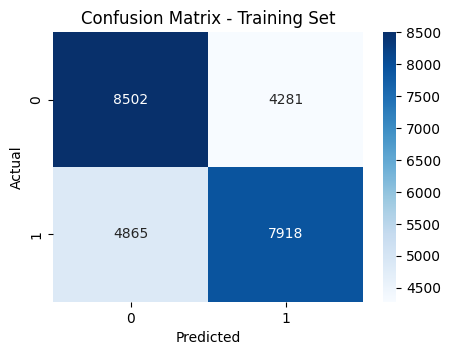

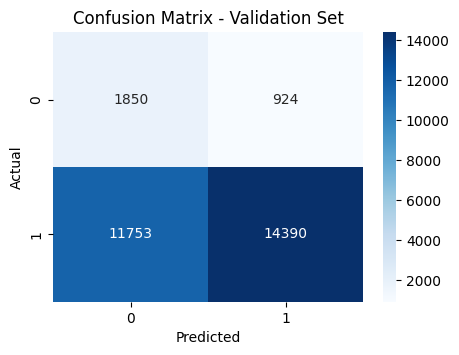

F1 Score (Train): 0.6338964054118966
F1 Score (Validation): 0.6942132812311552
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.14      0.67      0.23      2774
           1       0.94      0.55      0.69     26143

    accuracy                           0.56     28917
   macro avg       0.54      0.61      0.46     28917
weighted avg       0.86      0.56      0.65     28917



In [41]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Predicciones y evaluación del modelo
y_train_pred = model.predict(X_train_resampled)
y_val_pred = model.predict(X_val)

# Matrices de confusión
train_cm = confusion_matrix(y_train_resampled, y_train_pred)
val_cm = confusion_matrix(y_val, y_val_pred)

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5, 3.5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Graficar las matrices de confusión
plot_confusion_matrix(train_cm, 'Confusion Matrix - Training Set')
plot_confusion_matrix(val_cm, 'Confusion Matrix - Validation Set')

print(f"F1 Score (Train): {f1_score(y_train_resampled, y_train_pred)}")
print(f"F1 Score (Validation): {f1_score(y_val, y_val_pred)}")
print("Classification Report (Validation):")
print(classification_report(y_val, y_val_pred))

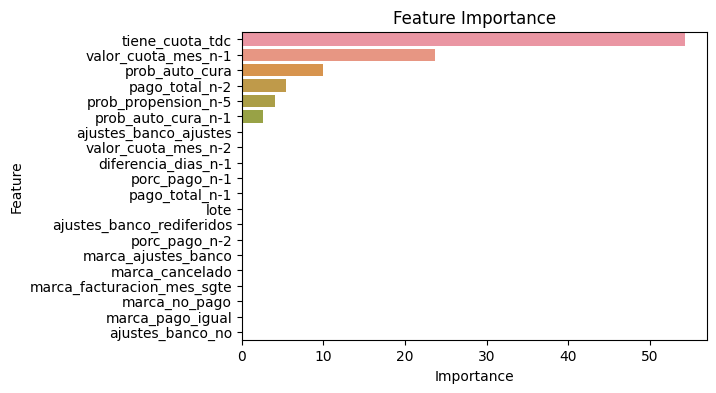

In [51]:
# Importancia de las características
feature_importances = model.get_feature_importance()
feature_importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Graficar la importancia de las características
plt.figure(figsize=(6, 4))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(20))
plt.title('Feature Importance')
plt.show()

In [53]:
feature_importances_df.head(10)

,Feature,Importance
31,tiene_cuota_tdc,54.299874
48,valor_cuota_mes_n-1,23.721669
3,prob_auto_cura,9.982236
53,pago_total_n-2,5.425498
21,prob_propension_n-5,4.030561
7,prob_auto_cura_n-1,2.540162
47,ajustes_banco_ajustes,0.000000
52,valor_cuota_mes_n-2,0.000000
51,diferencia_dias_n-1,0.000000
50,porc_pago_n-1,0.000000


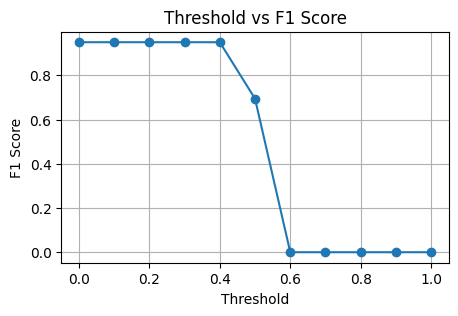

In [55]:
y_probs = model.predict_proba(X_val)[:, 1]

# Definir una serie de umbrales
thresholds = np.arange(0.0, 1.1, 0.1)

# Calcular f1_score para cada umbral
f1_scores = [f1_score(y_val, y_probs >= threshold) for threshold in thresholds]

# Graficar la curva threshold vs f1_score
plt.figure(figsize=(5, 3))
plt.plot(thresholds, f1_scores, marker='o')
plt.title('Threshold vs F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

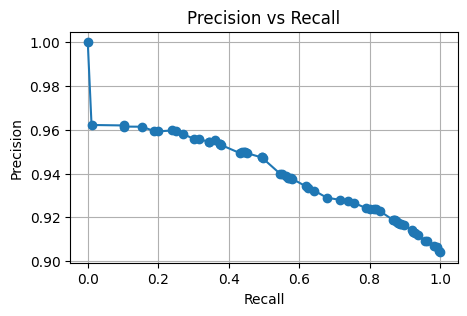

In [59]:
y_probs = model.predict_proba(X_val)[:, 1]

# Calcular las métricas de precisión y recuperación para diferentes umbrales
precision, recall, thresholds = precision_recall_curve(y_val, y_probs)

# Graficar la curva precision vs recall
plt.figure(figsize=(5, 3))
plt.plot(recall, precision, marker='o')
plt.title('Precision vs Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

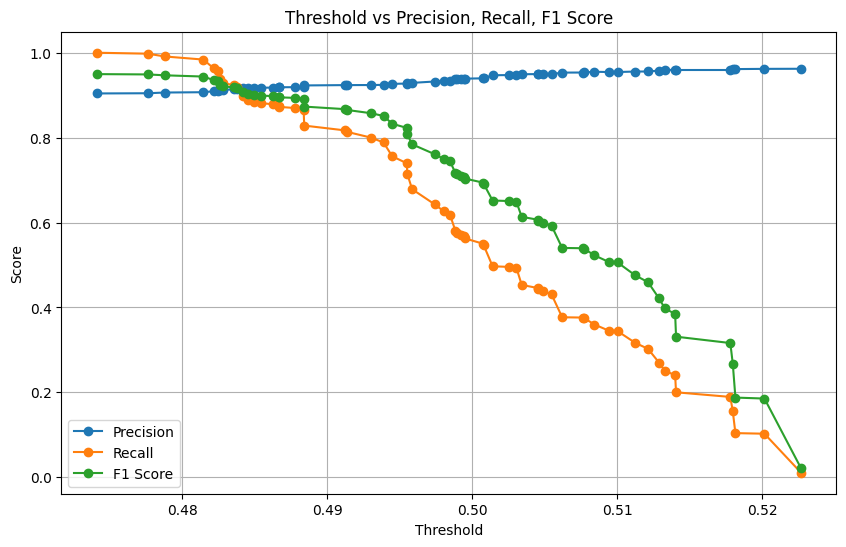

In [62]:
precision, recall, thresholds = precision_recall_curve(y_val, y_probs)

# Calcular f1_score para cada umbral
f1_scores = [f1_score(y_val, y_probs >= threshold) for threshold in thresholds]

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], marker='o', label='Precision')
plt.plot(thresholds, recall[:-1], marker='o', label='Recall')
plt.plot(thresholds, f1_scores, marker='o', label='F1 Score')
plt.title('Threshold vs Precision, Recall, F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

### Iter 2

Se modela sin la variable "tiene_cuota_tdc"

In [69]:
# Cargar los datos
df = muestra_train_val

# Definir las variables
features = ['lote'
,'prob_propension'
,'prob_alrt_temprana'
,'prob_auto_cura'
,'lote_n-1'
,'prob_propension_n-1'
,'prob_alrt_temprana_n-1'
,'prob_auto_cura_n-1'
,'lote_n-2'
,'prob_propension_n-2'
,'prob_alrt_temprana_n-2'
,'prob_auto_cura_n-2'
,'lote_n-3'
,'prob_propension_n-3'
,'prob_alrt_temprana_n-3'
,'prob_auto_cura_n-3'
,'lote_n-4'
,'prob_propension_n-4'
,'prob_alrt_temprana_n-4'
,'prob_auto_cura_n-4'
,'lote_n-5'
,'prob_propension_n-5'
,'prob_alrt_temprana_n-5'
,'prob_auto_cura_n-5'
,'lote_n-6'
,'prob_propension_n-6'
,'prob_alrt_temprana_n-6'
,'prob_auto_cura_n-6'
,'valor_cuota_mes'
,'pago_total'
,'porc_pago'
,'tiene_cuota_libr_inv'
,'tiene_cuota_rot'
,'tiene_cuota_cart_ordinaria'
,'tiene_cuota_hipo'
,'tiene_cuota_libranza'
,'diferencia_dias'
,'marca_pago_mas'
,'marca_pago_menos'
,'marca_pago_igual'
,'marca_no_pago'
,'marca_facturacion_mes_sgte'
,'marca_cancelado'
,'marca_ajustes_banco'
,'ajustes_banco_no'
,'ajustes_banco_rediferidos'
,'ajustes_banco_ajustes'
,'valor_cuota_mes_n-1'
,'pago_total_n-1'
,'porc_pago_n-1'
,'diferencia_dias_n-1'
,'valor_cuota_mes_n-2'
,'pago_total_n-2'
,'porc_pago_n-2'
,'diferencia_dias_n-2'
,'valor_cuota_mes_n-3'
,'pago_total_n-3'
,'porc_pago_n-3'
,'diferencia_dias_n-3'
,'valor_cuota_mes_n-4'
,'pago_total_n-4'
,'porc_pago_n-4'
,'diferencia_dias_n-4'
,'valor_cuota_mes_n-5'
,'pago_total_n-5'
,'porc_pago_n-5'
,'diferencia_dias_n-5'
,'valor_cuota_mes_n-6'
,'pago_total_n-6'
,'porc_pago_n-6'
,'diferencia_dias_n-6'
]
target = 'var_rpta_alt'

# Crear conjuntos de entrenamiento y validación
train_df = df[df['fecha_corte'] < 202311]  # Ajusta la fecha según tus datos
val_df = df[df['fecha_corte'] >= 202311]  # Ajusta la fecha según tus datos

# Under-sampling de la clase mayoritaria en el conjunto de entrenamiento
df_majority = train_df[train_df[target] == 1]
df_minority = train_df[train_df[target] == 0]

df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority),     # to match minority class
                                   random_state=42)  # reproducible results

train_df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Separar características y objetivo
X_train = train_df_downsampled[features]
y_train = train_df_downsampled[target]
X_val = val_df[features]
y_val = val_df[target]

# Crear y entrenar el modelo CatBoost
model = CatBoostClassifier(random_seed=42, logging_level='Silent')
model.fit(X_train, y_train)

# Predicciones y evaluación del modelo
y_pred = model.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[ 1721  1053]
 [ 9416 16727]]
              precision    recall  f1-score   support

           0       0.15      0.62      0.25      2774
           1       0.94      0.64      0.76     26143

    accuracy                           0.64     28917
   macro avg       0.55      0.63      0.50     28917
weighted avg       0.87      0.64      0.71     28917



In [70]:
# Cargar los datos
df 

# Definir las variables
features = features
target = 'var_rpta_alt'

# Crear conjuntos de entrenamiento y validación
train_df = df[df['fecha_corte'] < 202311]  # Ajusta la fecha según tus datos
val_df = df[df['fecha_corte'] >= 202311]  # Ajusta la fecha según tus datos

# Separar características y objetivo
X_train = train_df[features]
y_train = train_df[target]
X_val = val_df[features]
y_val = val_df[target]

# Under-sampling de la clase mayoritaria en el conjunto de entrenamiento
rus = RandomUnderSampler(sampling_strategy=1, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Crear y entrenar el modelo CatBoost
model = CatBoostClassifier(random_seed=42, logging_level='Silent', eval_metric='F1')
model.fit(X_train_resampled, y_train_resampled, eval_set=(X_val, y_val), early_stopping_rounds=10)

# Predicciones y evaluación del modelo
y_pred = model.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(f"F1 Score: {f1_score(y_val, y_pred)}")

[[ 1552  1222]
 [ 8870 17273]]
              precision    recall  f1-score   support

           0       0.15      0.56      0.24      2774
           1       0.93      0.66      0.77     26143

    accuracy                           0.65     28917
   macro avg       0.54      0.61      0.50     28917
weighted avg       0.86      0.65      0.72     28917

F1 Score: 0.7739146019086878


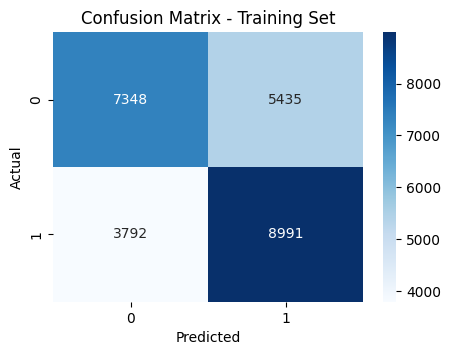

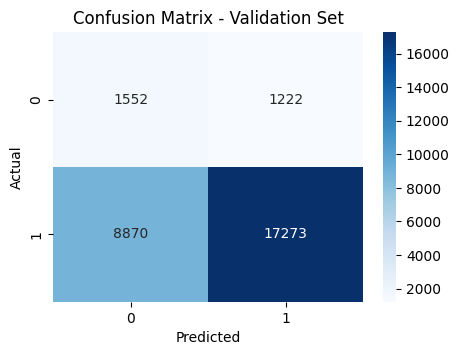

F1 Score (Train): 0.6608842662354368
F1 Score (Validation): 0.7739146019086878
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.15      0.56      0.24      2774
           1       0.93      0.66      0.77     26143

    accuracy                           0.65     28917
   macro avg       0.54      0.61      0.50     28917
weighted avg       0.86      0.65      0.72     28917



In [71]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Predicciones y evaluación del modelo
y_train_pred = model.predict(X_train_resampled)
y_val_pred = model.predict(X_val)

# Matrices de confusión
train_cm = confusion_matrix(y_train_resampled, y_train_pred)
val_cm = confusion_matrix(y_val, y_val_pred)

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5, 3.5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Graficar las matrices de confusión
plot_confusion_matrix(train_cm, 'Confusion Matrix - Training Set')
plot_confusion_matrix(val_cm, 'Confusion Matrix - Validation Set')

print(f"F1 Score (Train): {f1_score(y_train_resampled, y_train_pred)}")
print(f"F1 Score (Validation): {f1_score(y_val, y_val_pred)}")
print("Classification Report (Validation):")
print(classification_report(y_val, y_val_pred))

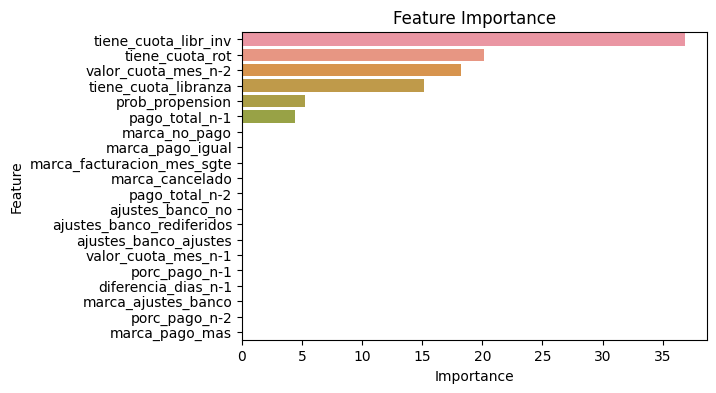

In [72]:
# Importancia de las características
feature_importances = model.get_feature_importance()
feature_importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Graficar la importancia de las características
plt.figure(figsize=(6, 4))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(20))
plt.title('Feature Importance')
plt.show()

In [74]:
feature_importances_df.head(10)

,Feature,Importance
31,tiene_cuota_libr_inv,36.838355
32,tiene_cuota_rot,20.102370
51,valor_cuota_mes_n-2,18.228578
35,tiene_cuota_libranza,15.160342
1,prob_propension,5.213327
48,pago_total_n-1,4.457028
40,marca_no_pago,0.000000
39,marca_pago_igual,0.000000
41,marca_facturacion_mes_sgte,0.000000
42,marca_cancelado,0.000000


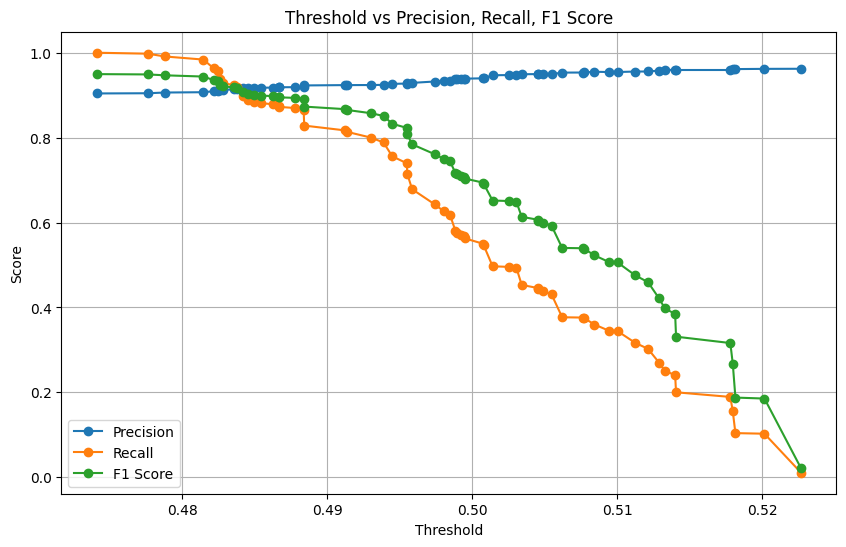

In [75]:
precision, recall, thresholds = precision_recall_curve(y_val, y_probs)

# Calcular f1_score para cada umbral
f1_scores = [f1_score(y_val, y_probs >= threshold) for threshold in thresholds]

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], marker='o', label='Precision')
plt.plot(thresholds, recall[:-1], marker='o', label='Recall')
plt.plot(thresholds, f1_scores, marker='o', label='F1 Score')
plt.title('Threshold vs Precision, Recall, F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

### Iter 3

Se extrae tiene_cuota_lib_inv

In [77]:
# Cargar los datos
df = muestra_train_val

# Definir las variables
features = ['lote'
,'prob_propension'
,'prob_alrt_temprana'
,'prob_auto_cura'
,'lote_n-1'
,'prob_propension_n-1'
,'prob_alrt_temprana_n-1'
,'prob_auto_cura_n-1'
,'lote_n-2'
,'prob_propension_n-2'
,'prob_alrt_temprana_n-2'
,'prob_auto_cura_n-2'
,'lote_n-3'
,'prob_propension_n-3'
,'prob_alrt_temprana_n-3'
,'prob_auto_cura_n-3'
,'lote_n-4'
,'prob_propension_n-4'
,'prob_alrt_temprana_n-4'
,'prob_auto_cura_n-4'
,'lote_n-5'
,'prob_propension_n-5'
,'prob_alrt_temprana_n-5'
,'prob_auto_cura_n-5'
,'lote_n-6'
,'prob_propension_n-6'
,'prob_alrt_temprana_n-6'
,'prob_auto_cura_n-6'
,'valor_cuota_mes'
,'pago_total'
,'porc_pago'
,'tiene_cuota_rot'
,'tiene_cuota_cart_ordinaria'
,'tiene_cuota_hipo'
,'tiene_cuota_libranza'
,'diferencia_dias'
,'marca_pago_mas'
,'marca_pago_menos'
,'marca_pago_igual'
,'marca_no_pago'
,'marca_facturacion_mes_sgte'
,'marca_cancelado'
,'marca_ajustes_banco'
,'ajustes_banco_no'
,'ajustes_banco_rediferidos'
,'ajustes_banco_ajustes'
,'valor_cuota_mes_n-1'
,'pago_total_n-1'
,'porc_pago_n-1'
,'diferencia_dias_n-1'
,'valor_cuota_mes_n-2'
,'pago_total_n-2'
,'porc_pago_n-2'
,'diferencia_dias_n-2'
,'valor_cuota_mes_n-3'
,'pago_total_n-3'
,'porc_pago_n-3'
,'diferencia_dias_n-3'
,'valor_cuota_mes_n-4'
,'pago_total_n-4'
,'porc_pago_n-4'
,'diferencia_dias_n-4'
,'valor_cuota_mes_n-5'
,'pago_total_n-5'
,'porc_pago_n-5'
,'diferencia_dias_n-5'
,'valor_cuota_mes_n-6'
,'pago_total_n-6'
,'porc_pago_n-6'
,'diferencia_dias_n-6'
]
target = 'var_rpta_alt'

# Crear conjuntos de entrenamiento y validación
train_df = df[df['fecha_corte'] < 202311]  # Ajusta la fecha según tus datos
val_df = df[df['fecha_corte'] >= 202311]  # Ajusta la fecha según tus datos

# Under-sampling de la clase mayoritaria en el conjunto de entrenamiento
df_majority = train_df[train_df[target] == 1]
df_minority = train_df[train_df[target] == 0]

df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority),     # to match minority class
                                   random_state=42)  # reproducible results

train_df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Separar características y objetivo
X_train = train_df_downsampled[features]
y_train = train_df_downsampled[target]
X_val = val_df[features]
y_val = val_df[target]

# Crear y entrenar el modelo CatBoost
model = CatBoostClassifier(random_seed=42, logging_level='Silent')
model.fit(X_train, y_train)

# Predicciones y evaluación del modelo
y_pred = model.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(f"F1 Score: {f1_score(y_val, y_pred)}")

[[ 1725  1049]
 [ 9487 16656]]
              precision    recall  f1-score   support

           0       0.15      0.62      0.25      2774
           1       0.94      0.64      0.76     26143

    accuracy                           0.64     28917
   macro avg       0.55      0.63      0.50     28917
weighted avg       0.87      0.64      0.71     28917

F1 Score: 0.7597153804050356


In [78]:
# Cargar los datos
df 

# Definir las variables
features = features
target = 'var_rpta_alt'

# Crear conjuntos de entrenamiento y validación
train_df = df[df['fecha_corte'] < 202311]  # Ajusta la fecha según tus datos
val_df = df[df['fecha_corte'] >= 202311]  # Ajusta la fecha según tus datos

# Separar características y objetivo
X_train = train_df[features]
y_train = train_df[target]
X_val = val_df[features]
y_val = val_df[target]

# Under-sampling de la clase mayoritaria en el conjunto de entrenamiento
rus = RandomUnderSampler(sampling_strategy=1, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Crear y entrenar el modelo CatBoost
model = CatBoostClassifier(random_seed=42, logging_level='Silent', eval_metric='F1')
model.fit(X_train_resampled, y_train_resampled, eval_set=(X_val, y_val), early_stopping_rounds=10)

# Predicciones y evaluación del modelo
y_pred = model.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(f"F1 Score: {f1_score(y_val, y_pred)}")

[[ 1714  1060]
 [10162 15981]]
              precision    recall  f1-score   support

           0       0.14      0.62      0.23      2774
           1       0.94      0.61      0.74     26143

    accuracy                           0.61     28917
   macro avg       0.54      0.61      0.49     28917
weighted avg       0.86      0.61      0.69     28917

F1 Score: 0.740135235272323


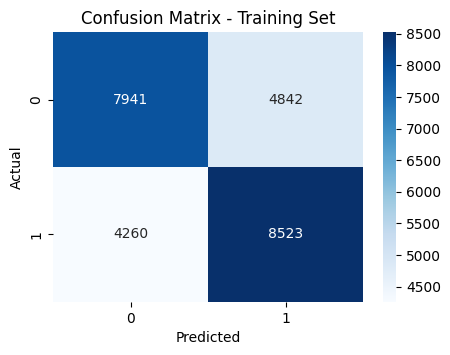

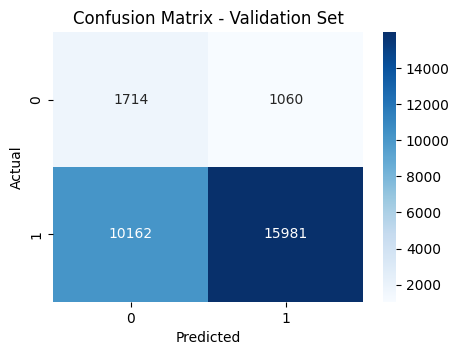

F1 Score (Train): 0.6519045433685177
F1 Score (Validation): 0.740135235272323
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.14      0.62      0.23      2774
           1       0.94      0.61      0.74     26143

    accuracy                           0.61     28917
   macro avg       0.54      0.61      0.49     28917
weighted avg       0.86      0.61      0.69     28917



In [79]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Predicciones y evaluación del modelo
y_train_pred = model.predict(X_train_resampled)
y_val_pred = model.predict(X_val)

# Matrices de confusión
train_cm = confusion_matrix(y_train_resampled, y_train_pred)
val_cm = confusion_matrix(y_val, y_val_pred)

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5, 3.5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Graficar las matrices de confusión
plot_confusion_matrix(train_cm, 'Confusion Matrix - Training Set')
plot_confusion_matrix(val_cm, 'Confusion Matrix - Validation Set')

print(f"F1 Score (Train): {f1_score(y_train_resampled, y_train_pred)}")
print(f"F1 Score (Validation): {f1_score(y_val, y_val_pred)}")
print("Classification Report (Validation):")
print(classification_report(y_val, y_val_pred))

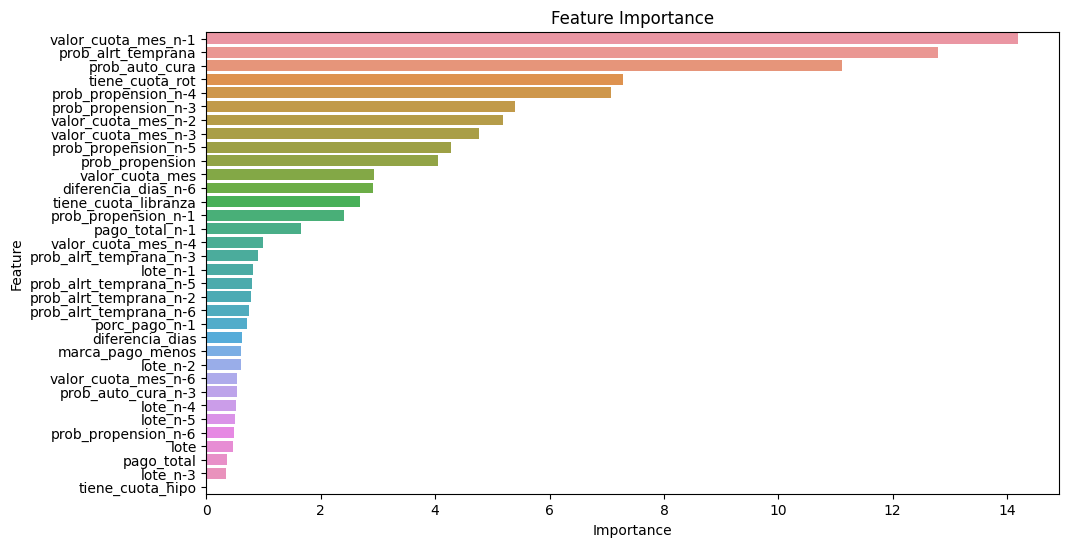

In [86]:
# Importancia de las características
feature_importances = model.get_feature_importance()
feature_importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Graficar la importancia de las características
plt.figure(figsize=(11, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(34))
plt.title('Feature Importance')
plt.show()

In [89]:
feature_importances_df.head(34)

,Feature,Importance
46,valor_cuota_mes_n-1,14.195703
2,prob_alrt_temprana,12.784085
3,prob_auto_cura,11.121702
31,tiene_cuota_rot,7.286193
17,prob_propension_n-4,7.078195
13,prob_propension_n-3,5.394298
50,valor_cuota_mes_n-2,5.179088
54,valor_cuota_mes_n-3,4.759003
21,prob_propension_n-5,4.278475
1,prob_propension,4.053258


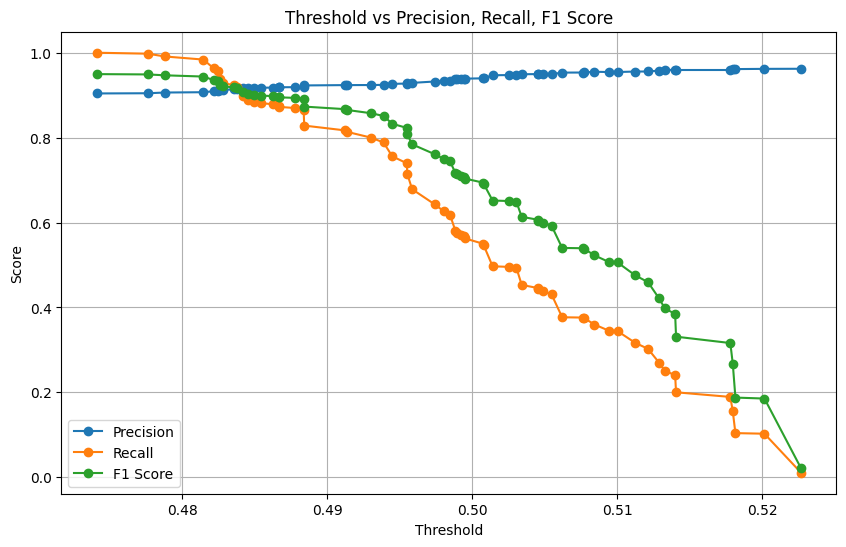

In [87]:
precision, recall, thresholds = precision_recall_curve(y_val, y_probs)

# Calcular f1_score para cada umbral
f1_scores = [f1_score(y_val, y_probs >= threshold) for threshold in thresholds]

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], marker='o', label='Precision')
plt.plot(thresholds, recall[:-1], marker='o', label='Recall')
plt.plot(thresholds, f1_scores, marker='o', label='F1 Score')
plt.title('Threshold vs Precision, Recall, F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

### Iter 4

In [90]:
# Cargar los datos
df = muestra_train_val

# Definir las variables
features = ['valor_cuota_mes_n-1'
,'prob_alrt_temprana'
,'prob_auto_cura'
,'tiene_cuota_rot'
,'prob_propension_n-4'
,'prob_propension_n-3'
,'valor_cuota_mes_n-2'
,'valor_cuota_mes_n-3'
,'prob_propension_n-5'
,'prob_propension'
,'valor_cuota_mes'
,'diferencia_dias_n-6'

]
target = 'var_rpta_alt'

# Crear conjuntos de entrenamiento y validación
train_df = df[df['fecha_corte'] < 202311]  # Ajusta la fecha según tus datos
val_df = df[df['fecha_corte'] >= 202311]  # Ajusta la fecha según tus datos

# Under-sampling de la clase mayoritaria en el conjunto de entrenamiento
df_majority = train_df[train_df[target] == 1]
df_minority = train_df[train_df[target] == 0]

df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority),     # to match minority class
                                   random_state=42)  # reproducible results

train_df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Separar características y objetivo
X_train = train_df_downsampled[features]
y_train = train_df_downsampled[target]
X_val = val_df[features]
y_val = val_df[target]

# Crear y entrenar el modelo CatBoost
model = CatBoostClassifier(random_seed=42, logging_level='Silent')
model.fit(X_train, y_train)

# Predicciones y evaluación del modelo
y_pred = model.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(f"F1 Score: {f1_score(y_val, y_pred)}")

[[ 1729  1045]
 [10195 15948]]
              precision    recall  f1-score   support

           0       0.15      0.62      0.24      2774
           1       0.94      0.61      0.74     26143

    accuracy                           0.61     28917
   macro avg       0.54      0.62      0.49     28917
weighted avg       0.86      0.61      0.69     28917

F1 Score: 0.7394287833827892


In [91]:
# Cargar los datos
df 

# Definir las variables
features = features
target = 'var_rpta_alt'

# Crear conjuntos de entrenamiento y validación
train_df = df[df['fecha_corte'] < 202311]  # Ajusta la fecha según tus datos
val_df = df[df['fecha_corte'] >= 202311]  # Ajusta la fecha según tus datos

# Separar características y objetivo
X_train = train_df[features]
y_train = train_df[target]
X_val = val_df[features]
y_val = val_df[target]

# Under-sampling de la clase mayoritaria en el conjunto de entrenamiento
rus = RandomUnderSampler(sampling_strategy=1, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Crear y entrenar el modelo CatBoost
model = CatBoostClassifier(random_seed=42, logging_level='Silent', eval_metric='F1')
model.fit(X_train_resampled, y_train_resampled, eval_set=(X_val, y_val), early_stopping_rounds=10)

# Predicciones y evaluación del modelo
y_pred = model.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(f"F1 Score: {f1_score(y_val, y_pred)}")

[[ 1605  1169]
 [ 9376 16767]]
              precision    recall  f1-score   support

           0       0.15      0.58      0.23      2774
           1       0.93      0.64      0.76     26143

    accuracy                           0.64     28917
   macro avg       0.54      0.61      0.50     28917
weighted avg       0.86      0.64      0.71     28917

F1 Score: 0.7607704349009732


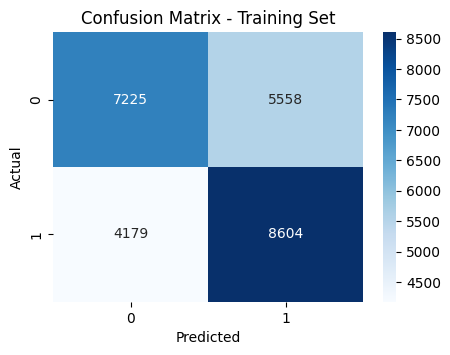

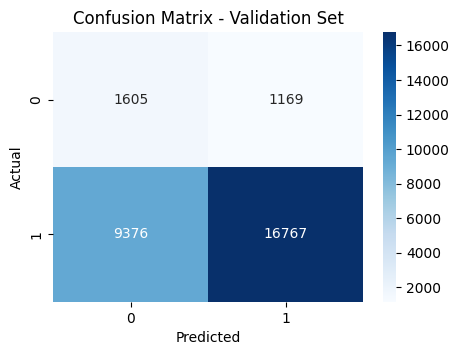

F1 Score (Train): 0.6386342549638152
F1 Score (Validation): 0.7607704349009732
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.15      0.58      0.23      2774
           1       0.93      0.64      0.76     26143

    accuracy                           0.64     28917
   macro avg       0.54      0.61      0.50     28917
weighted avg       0.86      0.64      0.71     28917



In [92]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Predicciones y evaluación del modelo
y_train_pred = model.predict(X_train_resampled)
y_val_pred = model.predict(X_val)

# Matrices de confusión
train_cm = confusion_matrix(y_train_resampled, y_train_pred)
val_cm = confusion_matrix(y_val, y_val_pred)

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5, 3.5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Graficar las matrices de confusión
plot_confusion_matrix(train_cm, 'Confusion Matrix - Training Set')
plot_confusion_matrix(val_cm, 'Confusion Matrix - Validation Set')

print(f"F1 Score (Train): {f1_score(y_train_resampled, y_train_pred)}")
print(f"F1 Score (Validation): {f1_score(y_val, y_val_pred)}")
print("Classification Report (Validation):")
print(classification_report(y_val, y_val_pred))

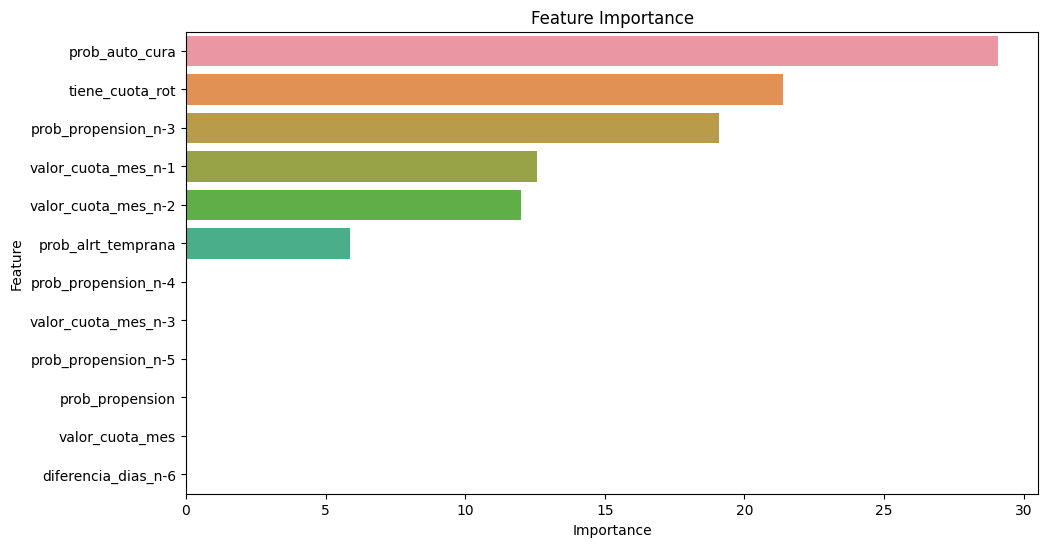

In [93]:
# Importancia de las características
feature_importances = model.get_feature_importance()
feature_importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Graficar la importancia de las características
plt.figure(figsize=(11, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(34))
plt.title('Feature Importance')
plt.show()

In [94]:
feature_importances_df.head(34)

,Feature,Importance
2,prob_auto_cura,29.072143
3,tiene_cuota_rot,21.376244
5,prob_propension_n-3,19.099162
0,valor_cuota_mes_n-1,12.569427
6,valor_cuota_mes_n-2,11.993241
1,prob_alrt_temprana,5.889783
4,prob_propension_n-4,0.000000
7,valor_cuota_mes_n-3,0.000000
8,prob_propension_n-5,0.000000
9,prob_propension,0.000000


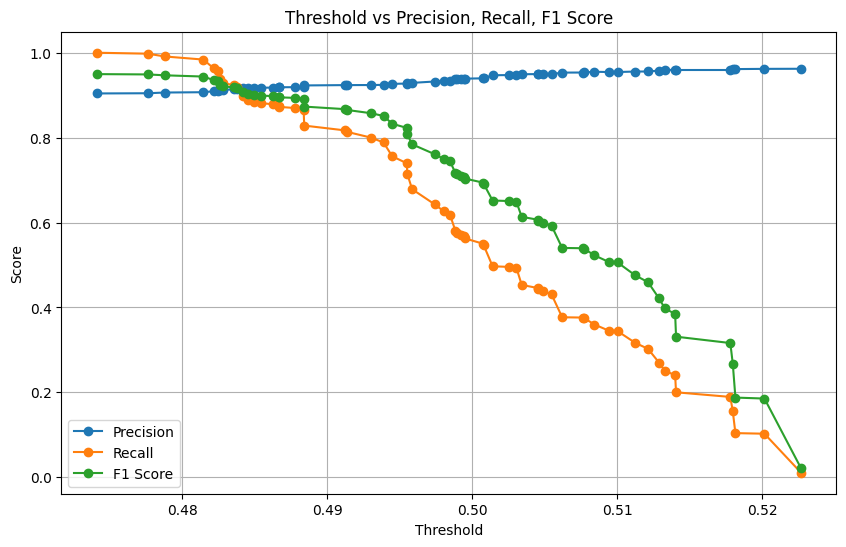

In [95]:
precision, recall, thresholds = precision_recall_curve(y_val, y_probs)

# Calcular f1_score para cada umbral
f1_scores = [f1_score(y_val, y_probs >= threshold) for threshold in thresholds]

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], marker='o', label='Precision')
plt.plot(thresholds, recall[:-1], marker='o', label='Recall')
plt.plot(thresholds, f1_scores, marker='o', label='F1 Score')
plt.title('Threshold vs Precision, Recall, F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

Comprende metricas 

In [96]:
# Asegúrate de que la tabla esté ordenada por 'fecha_corte'
muestra_train_val = muestra_train_val.sort_values(by='fecha_corte')

# Calcular los índices para dividir el DataFrame
train_end = int(0.8 * len(muestra_train_val))
val_end = int(0.9 * len(muestra_train_val))

# Crear los conjuntos de entrenamiento, validación y prueba
train_set = muestra_train_val.iloc[:train_end]
val_set = muestra_train_val.iloc[train_end:val_end]
test_set = muestra_train_val.iloc[val_end:]

# Mostrar las primeras filas de cada conjunto para verificar el resultado
print("Train Set:")
print(train_set.shape)
print("\nValidation Set:")
print(val_set.shape)
print("\nTest Set:")
print(test_set.shape)

Train Set:
(139115, 76)

Validation Set:
(17389, 76)

Test Set:
(17390, 76)


In [101]:
X_train= train_set[features]
y_train= train_set[target]

X_val = val_set[features]
y_val = val_set[target]

X_test = test_set[features]
y_test = test_set[target]

y_pred_train = predict(model, X_train)
y_pred_val = predict(model, X_val)
y_pred_test = predict(model, X_test)

# Consolidar los resultados
results = consolidate_results(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test, 'rus', 'cat_boost')  
            

results.head()

,tecnica_submuestreo,tecnica_ml,dataset,accuracy,precision,recall,specificity,f1_score,tn,fp,fn,tp
0,rus,cat_boost,Train,0.665550,0.941619,0.675150,0.566024,0.786425,6927,5311,41216,85661
1,rus,cat_boost,Validation,0.642475,0.935617,0.649460,0.576251,0.766708,956,703,5514,10216
2,rus,cat_boost,Test,0.636400,0.934183,0.643357,0.570482,0.761962,947,713,5610,10120


In [103]:
X_train= train_set[features]
y_train= train_set[target]

X_val = val_set[features]
y_val = val_set[target]

X_test = test_set[features]
y_test = test_set[target]

y_pred_train = predict(model, X_train)
y_pred_val = predict(model, X_val, threshold=0.49)
y_pred_test = predict(model, X_test, threshold=0.49)

# Consolidar los resultados
results = consolidate_results(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test, 'rus', 'cat_boost')  
            

results.head()

,tecnica_submuestreo,tecnica_ml,dataset,accuracy,precision,recall,specificity,f1_score,tn,fp,fn,tp
0,rus,cat_boost,Train,0.665550,0.941619,0.675150,0.566024,0.786425,6927,5311,41216,85661
1,rus,cat_boost,Validation,0.785037,0.923925,0.830769,0.351417,0.874874,583,1076,2662,13068
2,rus,cat_boost,Test,0.773778,0.924439,0.816656,0.367470,0.867211,610,1050,2884,12846


## Seleccion de Caracteristicas

In [116]:
df = muestra_train_val

features = [ 'lote' ,'prob_propension' ,'prob_alrt_temprana' ,'prob_auto_cura' ,'lote_n-1' ,
            'prob_propension_n-1' ,'prob_alrt_temprana_n-1' ,'prob_auto_cura_n-1' ,'lote_n-2' ,
            'prob_propension_n-2' ,'prob_alrt_temprana_n-2' ,'prob_auto_cura_n-2' ,'lote_n-3' ,
            'prob_propension_n-3' ,'prob_alrt_temprana_n-3' ,'prob_auto_cura_n-3' ,'lote_n-4' ,
            'prob_propension_n-4' ,'prob_alrt_temprana_n-4' ,'prob_auto_cura_n-4' ,'lote_n-5' ,
            'prob_propension_n-5' ,'prob_alrt_temprana_n-5' ,'prob_auto_cura_n-5' ,'lote_n-6' ,
            'prob_propension_n-6' ,'prob_alrt_temprana_n-6' ,'prob_auto_cura_n-6' ,'valor_cuota_mes' ,
            'pago_total' ,'porc_pago' ,'tiene_cuota_tdc' ,'tiene_cuota_libr_inv' ,'tiene_cuota_rot' ,
            'tiene_cuota_cart_ordinaria' ,'tiene_cuota_hipo' ,'tiene_cuota_libranza' ,'diferencia_dias' ,
            'marca_pago_mas' ,'marca_pago_menos' ,'marca_pago_igual' ,'marca_no_pago' ,'marca_facturacion_mes_sgte' 
            ,'marca_cancelado' ,'marca_ajustes_banco' ,'ajustes_banco_no' ,'ajustes_banco_rediferidos' 
            ,'ajustes_banco_ajustes' ,'valor_cuota_mes_n-1' ,'pago_total_n-1' ,'porc_pago_n-1' 
            ,'diferencia_dias_n-1' ,'valor_cuota_mes_n-2' ,'pago_total_n-2' ,'porc_pago_n-2' ,
            'diferencia_dias_n-2' ,'valor_cuota_mes_n-3' ,'pago_total_n-3' ,'porc_pago_n-3' ,'diferencia_dias_n-3' ,
            'valor_cuota_mes_n-4' ,'pago_total_n-4' ,'porc_pago_n-4' ,'diferencia_dias_n-4' ,'valor_cuota_mes_n-5' ,'pago_total_n-5' ,
            'porc_pago_n-5' ,'diferencia_dias_n-5' ,'valor_cuota_mes_n-6' ,'pago_total_n-6' ,'porc_pago_n-6' ,'diferencia_dias_n-6' ]

target = 'var_rpta_alt'

In [122]:
df_features = muestra_train_val[features]
df_features = convertir_a_numerico(df_features)

In [125]:
df_features = df_features.applymap(pd.to_numeric, errors='coerce')

In [127]:
# Define df_features as the DataFrame containing the features
df_features = muestra_train_val[features]

# Replace infinite or large values with NaN
df_features = df_features.replace([np.inf, -np.inf], np.nan)

# Scale the features using StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features)
df_scaled = pd.DataFrame(df_scaled, columns=df_features.columns)


In [128]:
df_transposed = df_scaled.transpose()

np.shape(df_transposed)

(72, 173894)

In [130]:
df_transposed = df_transposed.replace([np.inf, -np.inf, np.nan], 0)
linked = linkage(df_transposed, method='ward', metric='euclidean')


Text(0, 0.5, "Ward's distance")

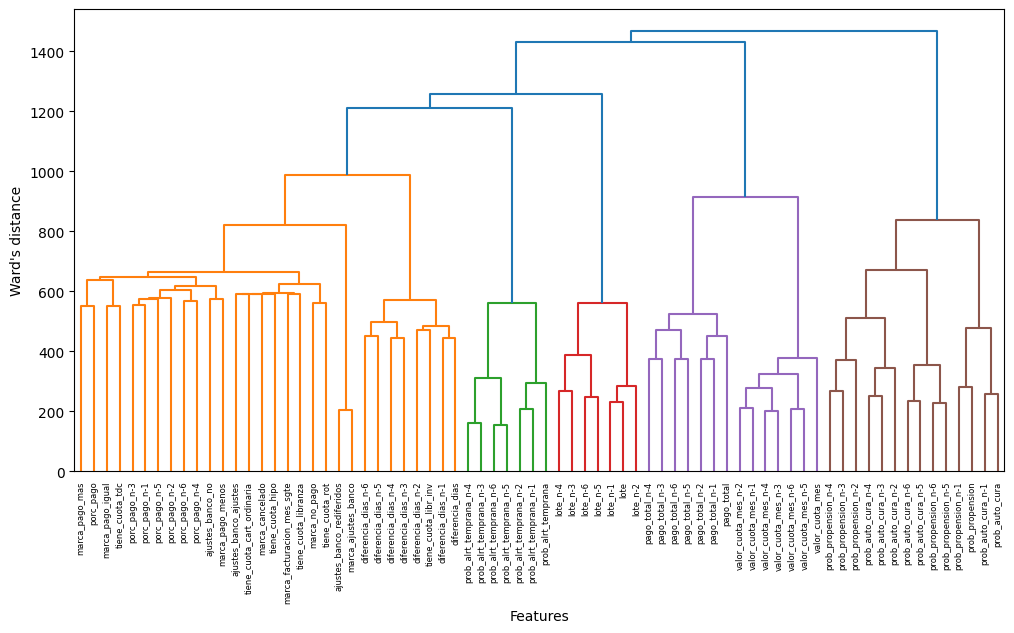

In [131]:
plt.figure(figsize=(12, 6)) 
dendrogram(linked ,
            orientation='top', 
            labels=df_transposed.index,
            distance_sort='descending', 
            show_leaf_counts=True)

plt.xlabel('Features')
plt.ylabel("Ward's distance")

In [132]:
# Definir el número de clusters de acuerdo a lo visto en el dendograma
num_clusters = 5

# Asignar etiquetas a la matriz de enlace 
labels = fcluster(linked, t=num_clusters, criterion='maxclust')

In [133]:
# Encontrar Correlaccion entre las caracteristicas y el target
correlations = []
for col in df_features.columns:
  # print(col)
  corr = muestra_train_val[target].corr(muestra_train_val[col])
  corr = round(corr, 3) 
  correlations.append(corr)

In [134]:
df_clusters = pd.DataFrame(list(zip(df_features.columns , labels , correlations)),
                          columns=['feature','cluster','corr'])

df_clusters['abs_corr'] = df_clusters['corr'].abs()

df_clusters.sort_values(by=['cluster','abs_corr'], ascending=[True,False], inplace=True) 
df_clusters.reset_index(drop=True, inplace=True)
df_clusters.head(10)

,feature,cluster,corr,abs_corr
0,prob_auto_cura,1,0.083,0.083
1,prob_auto_cura_n-1,1,0.067,0.067
2,prob_propension,1,0.046,0.046
3,prob_auto_cura_n-2,1,0.042,0.042
4,prob_auto_cura_n-3,1,0.033,0.033
5,prob_auto_cura_n-4,1,0.027,0.027
6,prob_propension_n-1,1,0.025,0.025
7,prob_auto_cura_n-5,1,0.021,0.021
8,prob_auto_cura_n-6,1,0.016,0.016
9,prob_propension_n-6,1,-0.007,0.007


In [136]:
df_clusters

,feature,cluster,corr,abs_corr
0,prob_auto_cura,1,0.083,0.083
1,prob_auto_cura_n-1,1,0.067,0.067
2,prob_propension,1,0.046,0.046
3,prob_auto_cura_n-2,1,0.042,0.042
4,prob_auto_cura_n-3,1,0.033,0.033
5,prob_auto_cura_n-4,1,0.027,0.027
6,prob_propension_n-1,1,0.025,0.025
7,prob_auto_cura_n-5,1,0.021,0.021
8,prob_auto_cura_n-6,1,0.016,0.016
9,prob_propension_n-6,1,-0.007,0.007


### Cluster 1

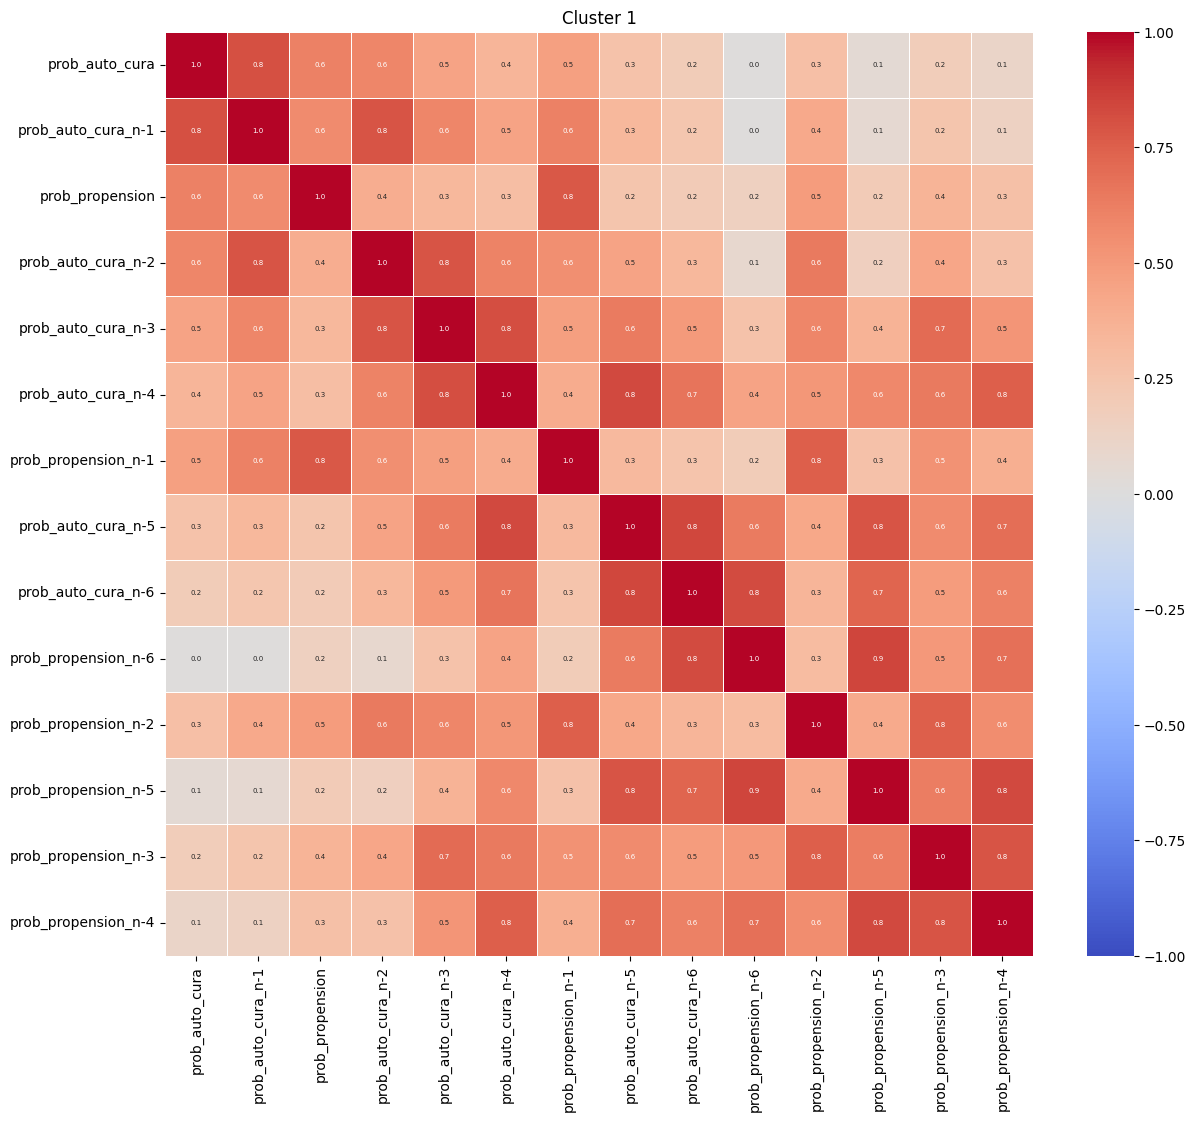

In [135]:
cluster = 1 # Que cluster deseas utilizar
c_features = df_clusters[df_clusters['cluster']==cluster]['feature'].tolist() 
corr = df_features[c_features].corr()
# corr = df_features.corr()

# plot correlation matrix
plt.figure(figsize=(14,12 )) 
sns.heatmap(corr,
annot=True, 
cmap='coolwarm',
linewidths=0.5, 
fmt=".1f",
annot_kws={"size": 5}, 
vmin=-1, vmax=1)
plt.title('Cluster {}'.format(cluster)) 
plt.show()

### Cluster 2

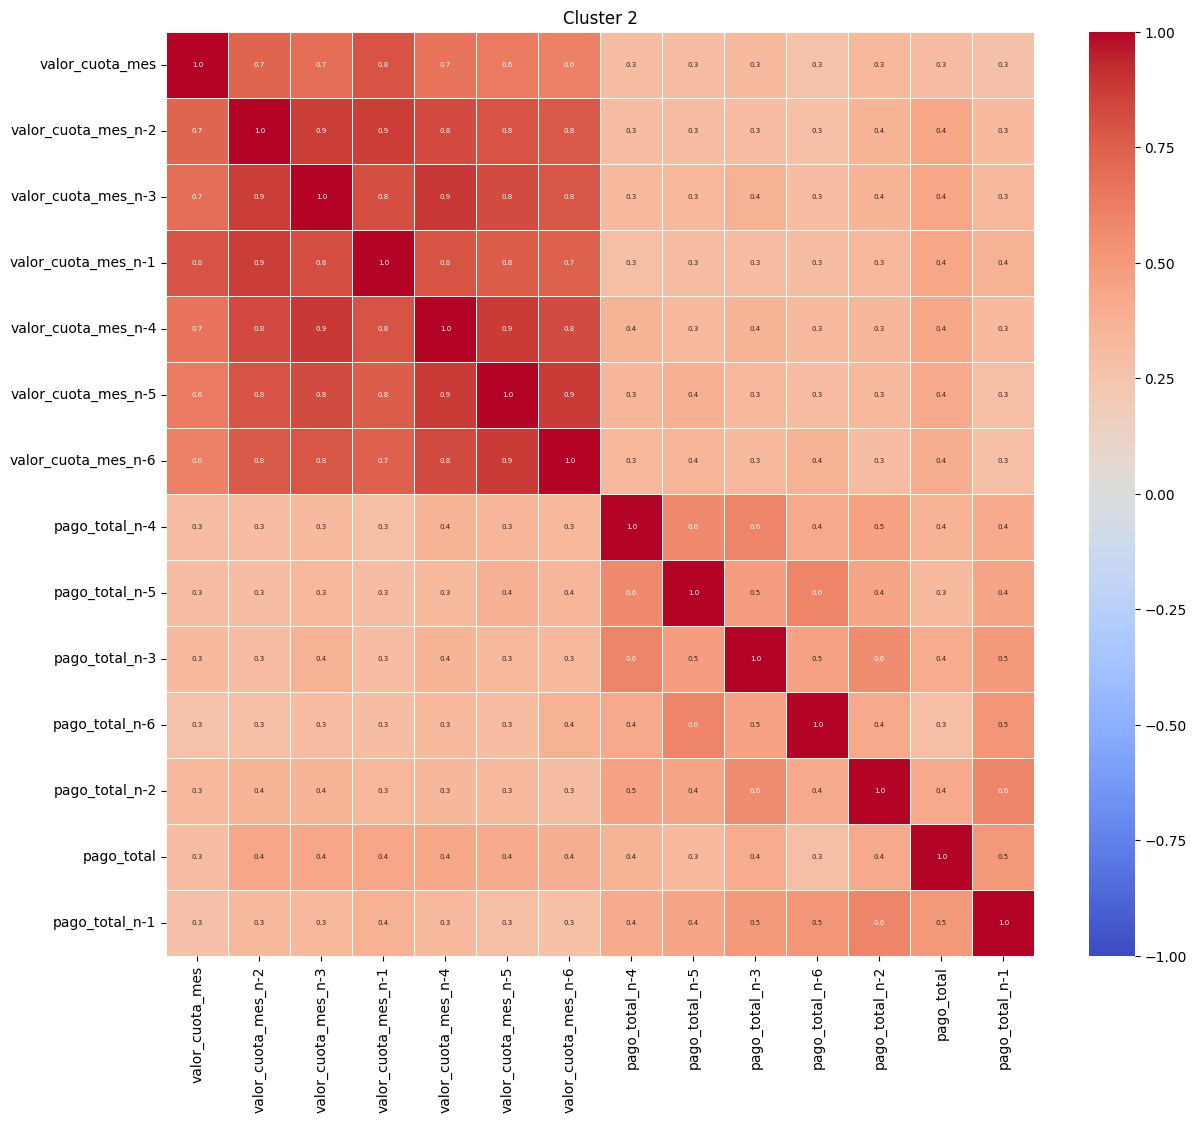

In [137]:
cluster = 2 # Que cluster deseas utilizar
c_features = df_clusters[df_clusters['cluster']==cluster]['feature'].tolist() 
corr = df_features[c_features].corr()
# corr = df_features.corr()

# plot correlation matrix
plt.figure(figsize=(14,12 )) 
sns.heatmap(corr,
annot=True, 
cmap='coolwarm',
linewidths=0.5, 
fmt=".1f",
annot_kws={"size": 5}, 
vmin=-1, vmax=1)
plt.title('Cluster {}'.format(cluster)) 
plt.show()

### Cluster 3

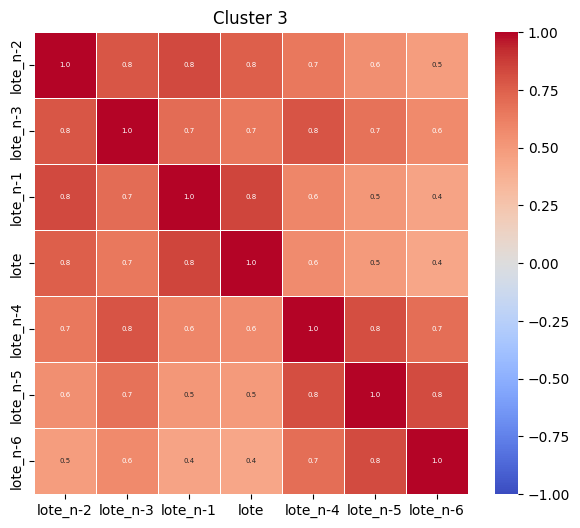

In [139]:
cluster = 3 # Que cluster deseas utilizar
c_features = df_clusters[df_clusters['cluster']==cluster]['feature'].tolist() 
corr = df_features[c_features].corr()
# corr = df_features.corr()

# plot correlation matrix
plt.figure(figsize=(7,6 )) 
sns.heatmap(corr,
annot=True, 
cmap='coolwarm',
linewidths=0.5, 
fmt=".1f",
annot_kws={"size": 5}, 
vmin=-1, vmax=1)
plt.title('Cluster {}'.format(cluster)) 
plt.show()

### Cluster 4

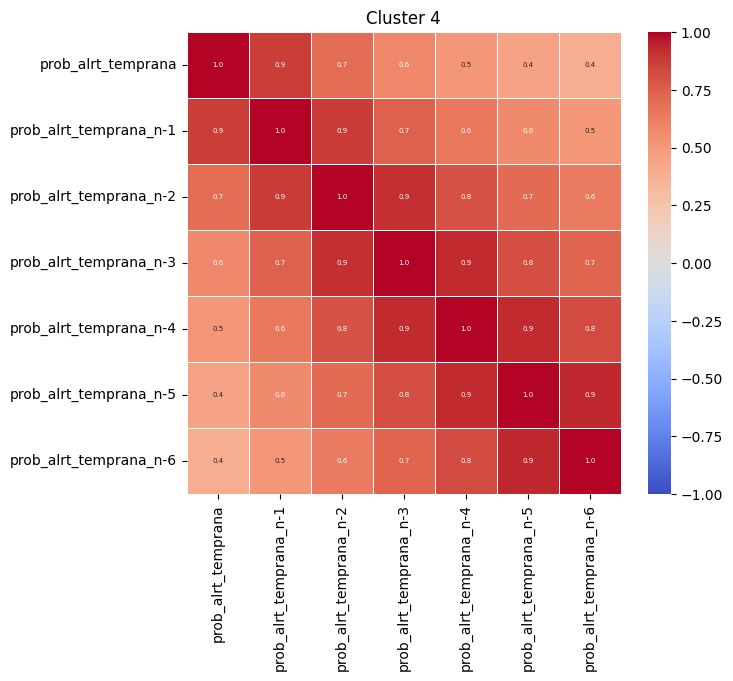

In [140]:
cluster = 4 # Que cluster deseas utilizar
c_features = df_clusters[df_clusters['cluster']==cluster]['feature'].tolist() 
corr = df_features[c_features].corr()
# corr = df_features.corr()

# plot correlation matrix
plt.figure(figsize=(7,6 )) 
sns.heatmap(corr,
annot=True, 
cmap='coolwarm',
linewidths=0.5, 
fmt=".1f",
annot_kws={"size": 5}, 
vmin=-1, vmax=1)
plt.title('Cluster {}'.format(cluster)) 
plt.show()

### Cluster 5

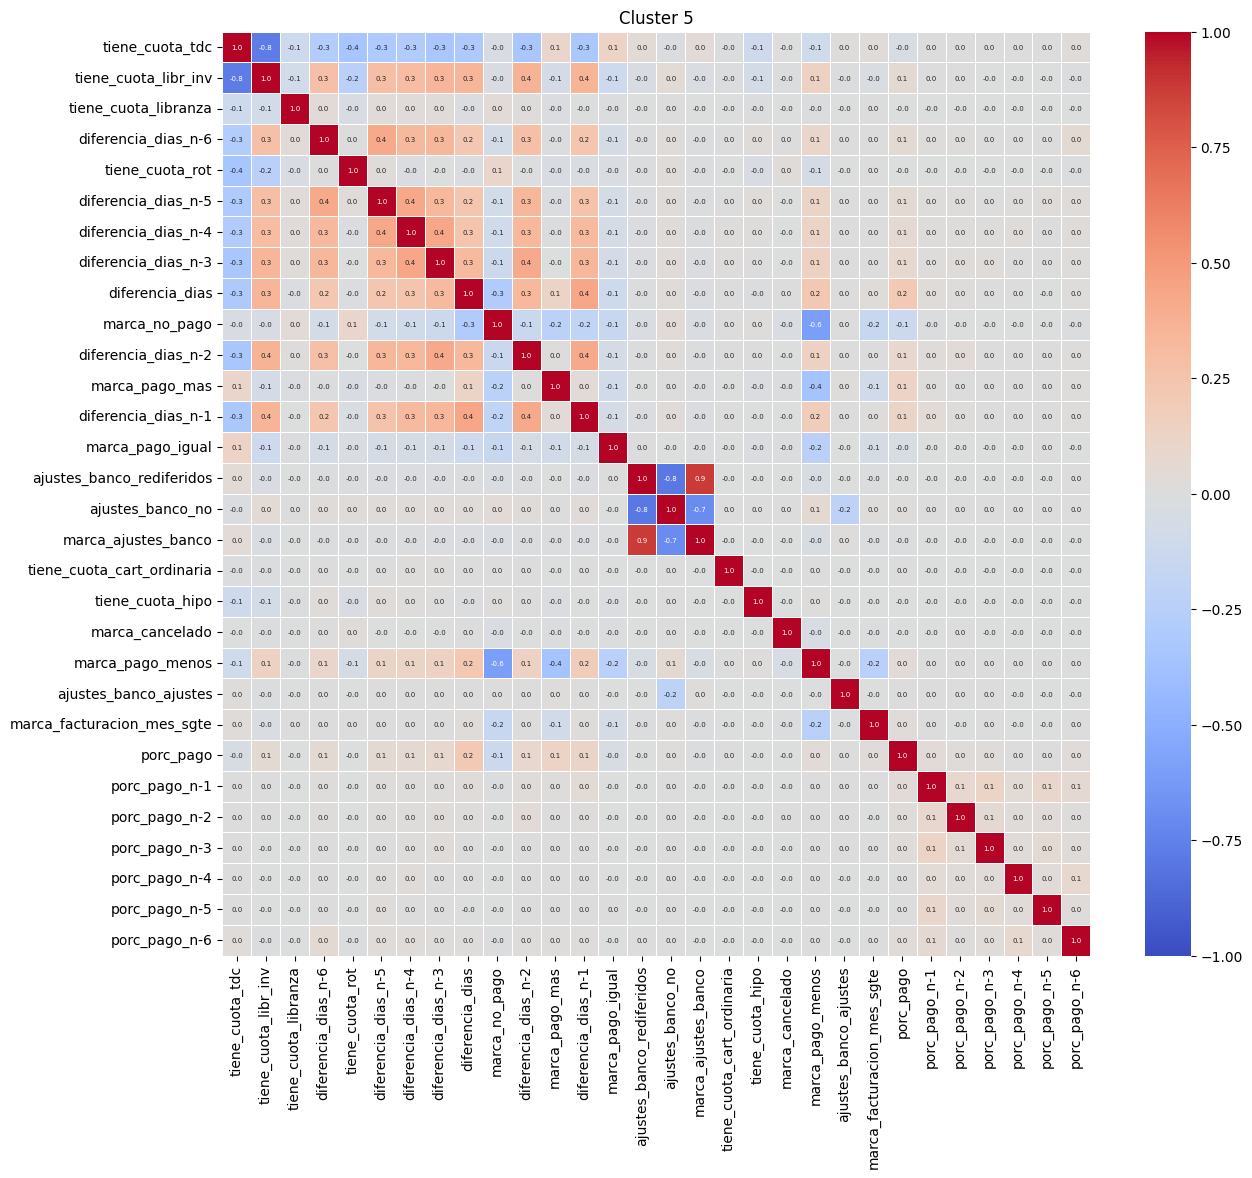

In [142]:
cluster = 5 # Que cluster deseas utilizar
c_features = df_clusters[df_clusters['cluster']==cluster]['feature'].tolist() 
corr = df_features[c_features].corr()
# corr = df_features.corr()

# plot correlation matrix
plt.figure(figsize=(14,12 )) 
sns.heatmap(corr,
annot=True, 
cmap='coolwarm',
linewidths=0.5, 
fmt=".1f",
annot_kws={"size": 5}, 
vmin=-1, vmax=1)
plt.title('Cluster {}'.format(cluster)) 
plt.show()

## Experimento 2

Con base en análisis por cluster, se define realizar otro experimento con las siguientes features

Cluster 1:
* prob_auto_cura
* prob_auto_cura_n-6
* prob_auto_cura_n-2
* prob_auto_cura_n-3

Cluster 2:
* valor_cuota_mes
* valor_cuota_mes_n-2
* valor_cuota_mes_n-3
* pago_tota_n-4

Cluster 3:
* lote_n-2
* lote_n-1

Cluster 4:
* prob_alrt_temprana

Cluster 5:
* tiene_cuota_tdc
* tiene_cuota_libre_inv
* tiene_cuota_libranza
* diferencia_dias_n-6
* tiene_cuota_rot
* diferencia_dias_n-5
* diferencia_dias_n-4
* diferencia_dias_n-3
* diferencia_dias


### Iter 1

In [16]:
muestra_train_val = muestra_train_val.sort_values(by='fecha_corte')

train_end = int(0.8 * len(muestra_train_val))
val_end = int(0.9 * len(muestra_train_val))

train_set = muestra_train_val.iloc[:train_end]
val_set = muestra_train_val.iloc[train_end:val_end]
test_set = muestra_train_val.iloc[val_end:]

print("Train Set:")
print(train_set.shape)
print("\nValidation Set:")
print(val_set.shape)
print("\nTest Set:")
print(test_set.shape)

Train Set:
(139115, 76)

Validation Set:
(17389, 76)

Test Set:
(17390, 76)


In [ ]:

features = ['prob_auto_cura'
,'prob_auto_cura_n-6'
,'prob_propension_n-2'
,'prob_propension_n-3'
,'valor_cuota_mes'
,'valor_cuota_mes_n-2'
,'valor_cuota_mes_n-3'
,'pago_total_n-4'
,'lote_n-2'
,'lote_n-1'
,'prob_alrt_temprana'
,'tiene_cuota_tdc'
,'tiene_cuota_libr_inv'
,'tiene_cuota_libranza'
,'diferencia_dias_n-6'
,'tiene_cuota_rot'
,'diferencia_dias_n-5'
,'diferencia_dias_n-4'
,'diferencia_dias_n-3'
,'diferencia_dias'


]
target = 'var_rpta_alt'

In [ ]:
features = features
target = 'var_rpta_alt'

# Separar características y objetivo
X_train = train_set[features]
y_train = train_set[target]
X_val = val_set[features]
y_val = val_set[target]
X_test = test_set[features]
y_test = test_set[target]

# Under-sampling de la clase mayoritaria en el conjunto de entrenamiento
rus = RandomUnderSampler(sampling_strategy=1, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Crear y entrenar el modelo CatBoost
model = CatBoostClassifier(random_seed=42, logging_level='Silent', eval_metric='F1')
model.fit(X_train_resampled, y_train_resampled, eval_set=(X_val, y_val), early_stopping_rounds=10)

# Predicciones y evaluación del modelo
y_pred = model.predict(X_val)
y_pred_test = model.predict(X_test)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(f"F1 Score val: {f1_score(y_val, y_pred)}")
print(f"F1 Score test: {f1_score(y_test, y_pred_test)}")

[[1057  551]
 [6304 9477]]
              precision    recall  f1-score   support

           0       0.14      0.66      0.24      1608
           1       0.95      0.60      0.73     15781

    accuracy                           0.61     17389
   macro avg       0.54      0.63      0.49     17389
weighted avg       0.87      0.61      0.69     17389

F1 Score val: 0.7343949784958735
F1 Score test: 0.7161895749546565


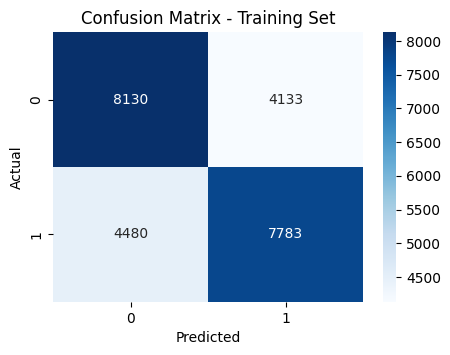

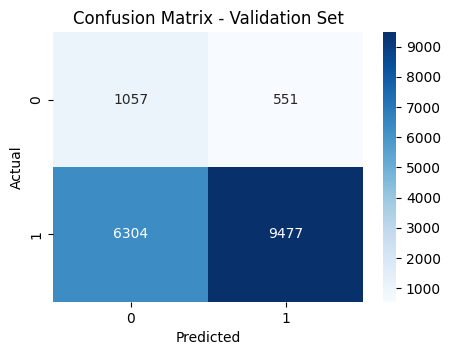

F1 Score (Train): 0.6437817941188635
F1 Score (Validation): 0.7343949784958735
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.14      0.66      0.24      1608
           1       0.95      0.60      0.73     15781

    accuracy                           0.61     17389
   macro avg       0.54      0.63      0.49     17389
weighted avg       0.87      0.61      0.69     17389



In [ ]:
# Predicciones y evaluación del modelo
y_train_pred = model.predict(X_train_resampled)
y_val_pred = model.predict(X_val)

# Matrices de confusión
train_cm = confusion_matrix(y_train_resampled, y_train_pred)
val_cm = confusion_matrix(y_val, y_val_pred)

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5, 3.5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Graficar las matrices de confusión
plot_confusion_matrix(train_cm, 'Confusion Matrix - Training Set')
plot_confusion_matrix(val_cm, 'Confusion Matrix - Validation Set')

print(f"F1 Score (Train): {f1_score(y_train_resampled, y_train_pred)}")
print(f"F1 Score (Validation): {f1_score(y_val, y_val_pred)}")
print("Classification Report (Validation):")
print(classification_report(y_val, y_val_pred))

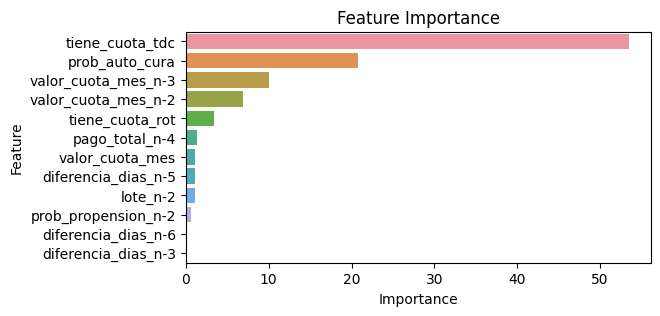

In [ ]:
# Importancia de las características
feature_importances = model.get_feature_importance()
feature_importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Graficar la importancia de las características
plt.figure(figsize=(6, 3))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(12))
plt.title('Feature Importance')
plt.show()

In [ ]:
feature_importances_df.head(15)

,Feature,Importance
11,tiene_cuota_tdc,53.437270
0,prob_auto_cura,20.762393
6,valor_cuota_mes_n-3,10.049922
5,valor_cuota_mes_n-2,6.954583
15,tiene_cuota_rot,3.433482
7,pago_total_n-4,1.367018
4,valor_cuota_mes,1.130195
16,diferencia_dias_n-5,1.124844
8,lote_n-2,1.077910
2,prob_propension_n-2,0.662384


In [ ]:
X_train= train_set[features]
y_train= train_set[target]

X_val = val_set[features]
y_val = val_set[target]

X_test = test_set[features]
y_test = test_set[target]

y_pred_train = predict(model, X_train)
y_pred_val = predict(model, X_val)
y_pred_test = predict(model, X_test)

# Consolidar los resultados
results = consolidate_results(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test, 'rus', 'cat_boost')  
results

,tecnica_submuestreo,tecnica_ml,dataset,accuracy,precision,recall,specificity,f1_score,tn,fp,fn,tp
0,rus,cat_boost,Train,0.632477,0.950792,0.629529,0.662970,0.757506,8130,4133,46995,79857
1,rus,cat_boost,Validation,0.605785,0.945054,0.600532,0.657338,0.734395,1057,551,6304,9477
2,rus,cat_boost,Test,0.586084,0.940360,0.578324,0.658363,0.716190,1110,576,6622,9082


In [ ]:
X_train= train_set[features]
y_train= train_set[target]

X_val = val_set[features]
y_val = val_set[target]

X_test = test_set[features]
y_test = test_set[target]

y_pred_train = predict(model, X_train,0.483)
y_pred_val = predict(model, X_val,0.483)
y_pred_test = predict(model, X_test,0.483)

# Consolidar los resultados
results = consolidate_results(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test, 'rus', 'cat_boost') 
results

,tecnica_submuestreo,tecnica_ml,dataset,accuracy,precision,recall,specificity,f1_score,tn,fp,fn,tp
0,rus,cat_boost,Train,0.740078,0.941952,0.761904,0.514311,0.842415,6307,5956,30203,96649
1,rus,cat_boost,Validation,0.720858,0.935929,0.743299,0.500622,0.828565,805,803,4051,11730
2,rus,cat_boost,Test,0.705865,0.930762,0.728477,0.495255,0.817289,835,851,4264,11440


### Iter 2

Se decide eliminar las variables de tiene_cuota_tdc y tiene_cuota_libr_inv, ya que pueden inducir sesgos en el modelo porque representan la gran mayoria de tenencias

In [157]:
features = ['prob_auto_cura'
,'prob_auto_cura_n-6'
,'prob_propension_n-2'
,'prob_propension_n-3'
,'valor_cuota_mes'
,'valor_cuota_mes_n-2'
,'valor_cuota_mes_n-3'
,'pago_total_n-4'
,'lote_n-2'
,'lote_n-1'
,'prob_alrt_temprana'
,'tiene_cuota_libranza'
,'diferencia_dias_n-6'
,'tiene_cuota_rot'
,'diferencia_dias_n-5'
,'diferencia_dias_n-4'
,'diferencia_dias_n-3'
,'diferencia_dias'

]

In [158]:
features = features
target = 'var_rpta_alt'

# Separar características y objetivo
X_train = train_set[features]
y_train = train_set[target]
X_val = val_set[features]
y_val = val_set[target]
X_test = test_set[features]
y_test = test_set[target]

# Under-sampling de la clase mayoritaria en el conjunto de entrenamiento
rus = RandomUnderSampler(sampling_strategy=1, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Crear y entrenar el modelo CatBoost
model = CatBoostClassifier(random_seed=42, logging_level='Silent', eval_metric='F1')
model.fit(X_train_resampled, y_train_resampled, eval_set=(X_val, y_val), early_stopping_rounds=10)

# Predicciones y evaluación del modelo
y_pred = model.predict(X_val)
y_pred_test = model.predict(X_test)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(f"F1 Score val: {f1_score(y_val, y_pred)}")
print(f"F1 Score test: {f1_score(y_test, y_pred_test)}")

[[1041  567]
 [6183 9598]]
              precision    recall  f1-score   support

           0       0.14      0.65      0.24      1608
           1       0.94      0.61      0.74     15781

    accuracy                           0.61     17389
   macro avg       0.54      0.63      0.49     17389
weighted avg       0.87      0.61      0.69     17389

F1 Score val: 0.7398442919910584
F1 Score test: 0.7272230676187131


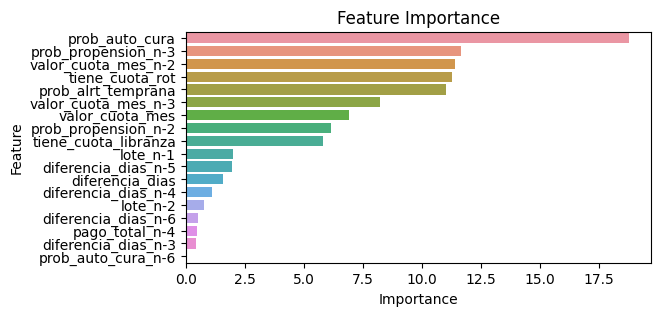

In [160]:
# Importancia de las características
feature_importances = model.get_feature_importance()
feature_importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Graficar la importancia de las características
plt.figure(figsize=(6, 3))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(20))
plt.title('Feature Importance')
plt.show()

In [163]:
feature_importances_df.head(25)

,Feature,Importance
0,prob_auto_cura,18.758177
3,prob_propension_n-3,11.678254
5,valor_cuota_mes_n-2,11.393723
13,tiene_cuota_rot,11.263455
10,prob_alrt_temprana,11.025158
6,valor_cuota_mes_n-3,8.212024
4,valor_cuota_mes,6.895105
2,prob_propension_n-2,6.154892
11,tiene_cuota_libranza,5.800420
9,lote_n-1,1.981634


In [161]:
X_train= train_set[features]
y_train= train_set[target]

X_val = val_set[features]
y_val = val_set[target]

X_test = test_set[features]
y_test = test_set[target]

y_pred_train = predict(model, X_train)
y_pred_val = predict(model, X_val)
y_pred_test = predict(model, X_test)

# Consolidar los resultados
results = consolidate_results(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test, 'rus', 'cat_boost')  
results

,tecnica_submuestreo,tecnica_ml,dataset,accuracy,precision,recall,specificity,f1_score,tn,fp,fn,tp
0,rus,cat_boost,Train,0.639557,0.947988,0.639816,0.636875,0.763996,7810,4453,45690,81162
1,rus,cat_boost,Validation,0.611824,0.944220,0.608200,0.647388,0.739844,1041,567,6183,9598
2,rus,cat_boost,Test,0.597987,0.938942,0.593416,0.640569,0.727223,1080,606,6385,9319


In [167]:
X_train= train_set[features]
y_train= train_set[target]

X_val = val_set[features]
y_val = val_set[target]

X_test = test_set[features]
y_test = test_set[target]

y_pred_train = predict(model, X_train,0.39)
y_pred_val = predict(model, X_val,0.39)
y_pred_test = predict(model, X_test,0.39)

# Consolidar los resultados
results = consolidate_results(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test, 'rus', 'cat_boost') 
results

,tecnica_submuestreo,tecnica_ml,dataset,accuracy,precision,recall,specificity,f1_score,tn,fp,fn,tp
0,rus,cat_boost,Train,0.858383,0.926010,0.918046,0.241213,0.922011,2958,9305,10396,116456
1,rus,cat_boost,Validation,0.845765,0.922685,0.905963,0.254975,0.914247,410,1198,1484,14297
2,rus,cat_boost,Test,0.834215,0.916835,0.897860,0.241400,0.907248,407,1279,1604,14100


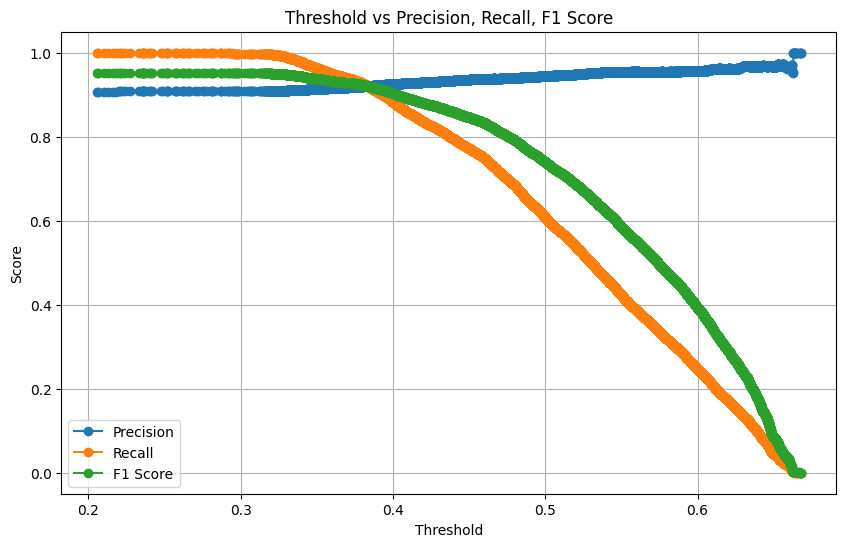

In [166]:
y_probs = model.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, y_probs)

# Calcular f1_score para cada umbral
f1_scores = [f1_score(y_val, y_probs >= threshold) for threshold in thresholds]

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], marker='o', label='Precision')
plt.plot(thresholds, recall[:-1], marker='o', label='Recall')
plt.plot(thresholds, f1_scores, marker='o', label='F1 Score')
plt.title('Threshold vs Precision, Recall, F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

### Iter 3

Se tomaran las variales mas representaivas por cluster

In [18]:
features = ['prob_auto_cura'
,'valor_cuota_mes_n-2'
,'diferencia_dias_n-5'
,'lote_n-1'
,'prob_alrt_temprana'

]
target = 'var_rpta_alt'

# Separar características y objetivo
X_train = train_set[features]
y_train = train_set[target]
X_val = val_set[features]
y_val = val_set[target]
X_test = test_set[features]
y_test = test_set[target]

In [169]:
features = features
target = 'var_rpta_alt'

# Separar características y objetivo
X_train = train_set[features]
y_train = train_set[target]
X_val = val_set[features]
y_val = val_set[target]
X_test = test_set[features]
y_test = test_set[target]

# Under-sampling de la clase mayoritaria en el conjunto de entrenamiento
rus = RandomUnderSampler(sampling_strategy=1, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Crear y entrenar el modelo CatBoost
model = CatBoostClassifier(random_seed=42, logging_level='Silent', eval_metric='F1')
model.fit(X_train_resampled, y_train_resampled, eval_set=(X_val, y_val), early_stopping_rounds=10)

# Predicciones y evaluación del modelo
y_pred = model.predict(X_val)
y_pred_test = model.predict(X_test)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(f"F1 Score val: {f1_score(y_val, y_pred)}")
print(f"F1 Score test: {f1_score(y_test, y_pred_test)}")

[[  855   753]
 [ 5392 10389]]
              precision    recall  f1-score   support

           0       0.14      0.53      0.22      1608
           1       0.93      0.66      0.77     15781

    accuracy                           0.65     17389
   macro avg       0.53      0.60      0.49     17389
weighted avg       0.86      0.65      0.72     17389

F1 Score val: 0.7717564907328308
F1 Score test: 0.7458708281125414


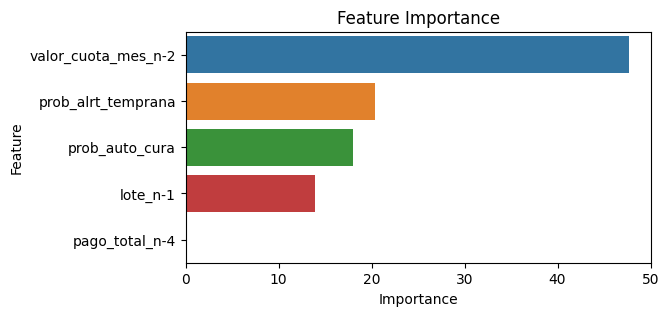

In [170]:
# Importancia de las características
feature_importances = model.get_feature_importance()
feature_importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Graficar la importancia de las características
plt.figure(figsize=(6, 3))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(20))
plt.title('Feature Importance')
plt.show()

In [171]:
feature_importances_df.head(25)

,Feature,Importance
1,valor_cuota_mes_n-2,47.647103
4,prob_alrt_temprana,20.376250
0,prob_auto_cura,18.034652
3,lote_n-1,13.941996
2,pago_total_n-4,0.000000


In [172]:
X_train= train_set[features]
y_train= train_set[target]

X_val = val_set[features]
y_val = val_set[target]

X_test = test_set[features]
y_test = test_set[target]

y_pred_train = predict(model, X_train)
y_pred_val = predict(model, X_val)
y_pred_test = predict(model, X_test)

# Consolidar los resultados
results = consolidate_results(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test, 'rus', 'cat_boost')  
results

,tecnica_submuestreo,tecnica_ml,dataset,accuracy,precision,recall,specificity,f1_score,tn,fp,fn,tp
0,rus,cat_boost,Train,0.683140,0.934535,0.701660,0.491560,0.801525,6028,6235,37845,89007
1,rus,cat_boost,Validation,0.646616,0.932418,0.658323,0.531716,0.771756,855,753,5392,10389
2,rus,cat_boost,Test,0.615124,0.923728,0.625446,0.518980,0.745871,875,811,5882,9822


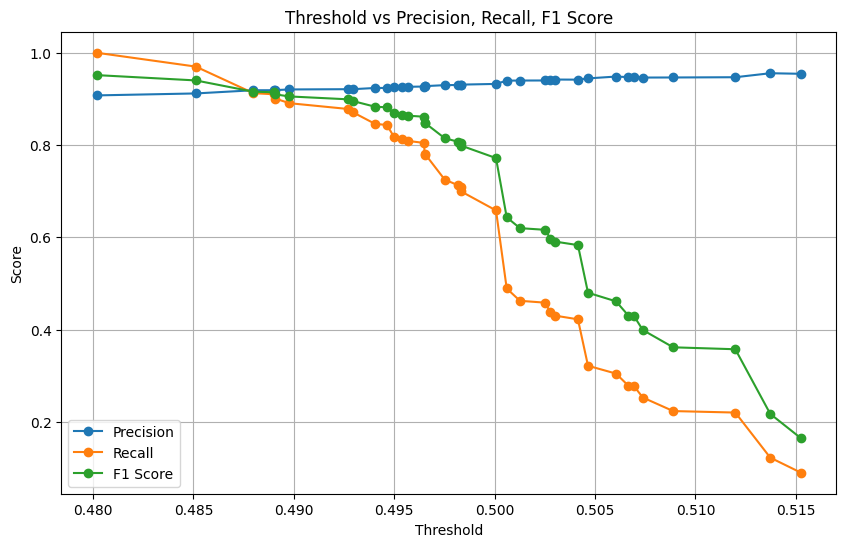

In [173]:
y_probs = model.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, y_probs)

# Calcular f1_score para cada umbral
f1_scores = [f1_score(y_val, y_probs >= threshold) for threshold in thresholds]

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], marker='o', label='Precision')
plt.plot(thresholds, recall[:-1], marker='o', label='Recall')
plt.plot(thresholds, f1_scores, marker='o', label='F1 Score')
plt.title('Threshold vs Precision, Recall, F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

In [174]:
X_train= train_set[features]
y_train= train_set[target]

X_val = val_set[features]
y_val = val_set[target]

X_test = test_set[features]
y_test = test_set[target]

y_pred_train = predict(model, X_train,0.487)
y_pred_val = predict(model, X_val,0.487)
y_pred_test = predict(model, X_test,0.487)

# Consolidar los resultados
results = consolidate_results(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test, 'rus', 'cat_boost') 
results

,tecnica_submuestreo,tecnica_ml,dataset,accuracy,precision,recall,specificity,f1_score,tn,fp,fn,tp
0,rus,cat_boost,Train,0.863545,0.922317,0.928562,0.190981,0.925429,2342,9921,9062,117790
1,rus,cat_boost,Validation,0.847202,0.918709,0.912363,0.207711,0.915525,334,1274,1383,14398
2,rus,cat_boost,Test,0.841691,0.913479,0.910978,0.196323,0.912227,331,1355,1398,14306


Iter 4

Se elimina la variable que no representativa

In [181]:
features = ['prob_auto_cura'
,'valor_cuota_mes_n-2'
,'lote_n-1'
,'prob_alrt_temprana'
]

In [182]:
features = features
target = 'var_rpta_alt'

# Separar características y objetivo
X_train = train_set[features]
y_train = train_set[target]
X_val = val_set[features]
y_val = val_set[target]
X_test = test_set[features]
y_test = test_set[target]

# Under-sampling de la clase mayoritaria en el conjunto de entrenamiento
rus = RandomUnderSampler(sampling_strategy=1, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Crear y entrenar el modelo CatBoost
model = CatBoostClassifier(random_seed=42, logging_level='Silent', eval_metric='F1')
model.fit(X_train_resampled, y_train_resampled, eval_set=(X_val, y_val), early_stopping_rounds=10)

# Predicciones y evaluación del modelo
y_pred = model.predict(X_val)
y_pred_test = model.predict(X_test)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(f"F1 Score val: {f1_score(y_val, y_pred)}")
print(f"F1 Score test: {f1_score(y_test, y_pred_test)}")

[[1006  602]
 [6407 9374]]
              precision    recall  f1-score   support

           0       0.14      0.63      0.22      1608
           1       0.94      0.59      0.73     15781

    accuracy                           0.60     17389
   macro avg       0.54      0.61      0.48     17389
weighted avg       0.87      0.60      0.68     17389

F1 Score val: 0.7278797996661102
F1 Score test: 0.7087470449172576


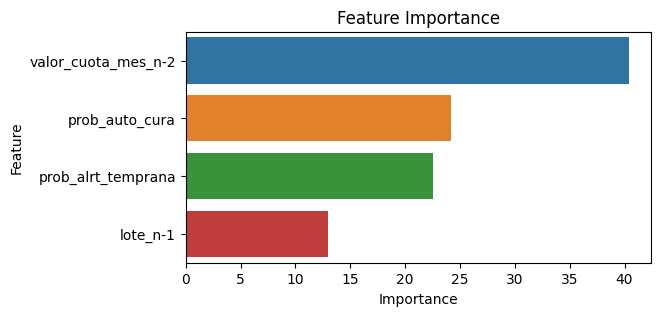

In [183]:
feature_importances = model.get_feature_importance()
feature_importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Graficar la importancia de las características
plt.figure(figsize=(6, 3))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(20))
plt.title('Feature Importance')
plt.show()

In [184]:
feature_importances_df.head(25)

,Feature,Importance
1,valor_cuota_mes_n-2,40.375749
0,prob_auto_cura,24.199516
3,prob_alrt_temprana,22.502585
2,lote_n-1,12.922150


In [186]:
X_train= train_set[features]
y_train= train_set[target]

X_val = val_set[features]
y_val = val_set[target]

X_test = test_set[features]
y_test = test_set[target]

y_pred_train = predict(model, X_train)
y_pred_val = predict(model, X_val)
y_pred_test = predict(model, X_test)

# Consolidar los resultados
results = consolidate_results(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test, 'rus', 'cat_boost')  
results

,tecnica_submuestreo,tecnica_ml,dataset,accuracy,precision,recall,specificity,f1_score,tn,fp,fn,tp
0,rus,cat_boost,Train,0.630363,0.941194,0.634259,0.590068,0.757827,7236,5027,46395,80457
1,rus,cat_boost,Validation,0.596929,0.939655,0.594005,0.625622,0.727880,1006,602,6407,9374
2,rus,cat_boost,Test,0.574928,0.929516,0.572720,0.595492,0.708747,1004,682,6710,8994


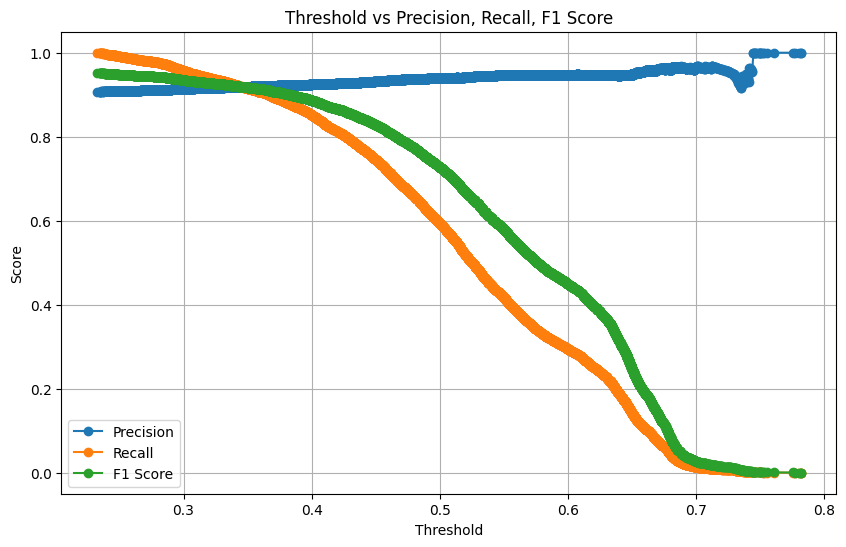

In [187]:
y_probs = model.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, y_probs)

# Calcular f1_score para cada umbral
f1_scores = [f1_score(y_val, y_probs >= threshold) for threshold in thresholds]

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], marker='o', label='Precision')
plt.plot(thresholds, recall[:-1], marker='o', label='Recall')
plt.plot(thresholds, f1_scores, marker='o', label='F1 Score')
plt.title('Threshold vs Precision, Recall, F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

In [188]:
X_train= train_set[features]
y_train= train_set[target]

X_val = val_set[features]
y_val = val_set[target]

X_test = test_set[features]
y_test = test_set[target]

y_pred_train = predict(model, X_train,0.35)
y_pred_val = predict(model, X_val,0.34)
y_pred_test = predict(model, X_test,0.35)

# Consolidar los resultados
results = consolidate_results(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test, 'rus', 'cat_boost') 
results

,tecnica_submuestreo,tecnica_ml,dataset,accuracy,precision,recall,specificity,f1_score,tn,fp,fn,tp
0,rus,cat_boost,Train,0.865176,0.922593,0.930186,0.192693,0.926374,2363,9900,8856,117996
1,rus,cat_boost,Validation,0.856116,0.918026,0.923959,0.190299,0.920983,306,1302,1200,14581
2,rus,cat_boost,Test,0.841978,0.913296,0.911551,0.193950,0.912423,327,1359,1389,14315


Se decide tomar las siguientes caracteristicas para modelar:

features = ['prob_auto_cura'
,'valor_cuota_mes_n-2'
,'lote_n-1'
,'prob_alrt_temprana'
]

## Optimización de modelos 

Se probaran 3 algoritmos, XGBoost, LGBM y CatBoost

In [23]:
features = ['prob_auto_cura'
,'valor_cuota_mes_n-2'
,'lote_n-1'
,'prob_alrt_temprana'
]
target = 'var_rpta_alt'
X_train = train_set[features]
y_train = train_set[target]
X_val = val_set[features]
y_val = val_set[target]
X_test = test_set[features]
y_test = test_set[target]

In [202]:


# Under-sampling de la clase mayoritaria en el conjunto de entrenamiento
rus = RandomUnderSampler(sampling_strategy=1, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Configurar los modelos
models = {
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_seed=42, logging_level='Silent', eval_metric='F1')
}

# Configurar la validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Función para evaluar modelos
def evaluate_model(model, X, y, cv):
    f1_scores = cross_val_score(model, X, y, scoring='f1', cv=cv)
    return f1_scores

# Evaluar y entrenar los modelos
for name, model in models.items():
    print(f"Evaluating {name}...")
    f1_scores = evaluate_model(model, X_train_resampled, y_train_resampled, cv)
    print(f"F1 Scores (Cross-Validation): {f1_scores}")
    print(f"Mean F1 Score: {np.mean(f1_scores)}\n")
    
    # Entrenar el modelo en todo el conjunto de entrenamiento resampleado
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predicciones y evaluación del modelo en el conjunto de validación
    y_pred_val = model.predict(X_val)
    print(f"Confusion Matrix (Validation) for {name}:\n{confusion_matrix(y_val, y_pred_val)}")
    print(f"Classification Report (Validation) for {name}:\n{classification_report(y_val, y_pred_val)}")
    print(f"F1 Score (Validation) for {name}: {f1_score(y_val, y_pred_val)}\n")
    
    # Predicciones y evaluación del modelo en el conjunto de prueba
    y_pred_test = model.predict(X_test)
    print(f"F1 Score (Test) for {name}: {f1_score(y_test, y_pred_test)}\n")

Evaluating XGBoost...
F1 Scores (Cross-Validation): [0.60583218 0.60801603 0.61156694 0.60181269 0.62093577]
Mean F1 Score: 0.6096327204942332

Confusion Matrix (Validation) for XGBoost:
[[ 950  658]
 [6280 9501]]
Classification Report (Validation) for XGBoost:
              precision    recall  f1-score   support

           0       0.13      0.59      0.21      1608
           1       0.94      0.60      0.73     15781

    accuracy                           0.60     17389
   macro avg       0.53      0.60      0.47     17389
weighted avg       0.86      0.60      0.68     17389

F1 Score (Validation) for XGBoost: 0.7325366229760987

F1 Score (Test) for XGBoost: 0.721205764673892

Evaluating LightGBM...
[LightGBM] [Info] Number of positive: 9810, number of negative: 9810
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wi

In [201]:
# Validacion cruzada solo con XGB
features = features
target = 'var_rpta_alt'

# Separar características y objetivo
X_train = train_set[features]
y_train = train_set[target]
X_val = val_set[features]
y_val = val_set[target]
X_test = test_set[features]
y_test = test_set[target]

# Under-sampling de la clase mayoritaria en el conjunto de entrenamiento
rus = RandomUnderSampler(sampling_strategy=1, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Crear el modelo XGBoost
model = XGBClassifier(random_state=42, eval_metric='logloss')

# Configurar la validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Realizar la validación cruzada y obtener las predicciones
y_pred_cv = cross_val_predict(model, X_train_resampled, y_train_resampled, cv=cv, method='predict')

# Entrenar el modelo en todo el conjunto de entrenamiento resampleado
model.fit(X_train_resampled, y_train_resampled, eval_set=[(X_val, y_val)],
          early_stopping_rounds=10, 
          verbose=True)

# Predicciones en el conjunto de validación y prueba
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

# Evaluación del modelo
print("Confusion Matrix (Validation):")
print(confusion_matrix(y_val, y_pred_val))
print("Classification Report (Validation):")
print(classification_report(y_val, y_pred_val))
print(f"F1 Score (Validation): {f1_score(y_val, y_pred_val)}")

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_test))
print("Classification Report (Test):")
print(classification_report(y_test, y_pred_test))
print(f"F1 Score (Test): {f1_score(y_test, y_pred_test)}")

[0]	validation_0-logloss:0.67975
[1]	validation_0-logloss:0.67360
[2]	validation_0-logloss:0.67028
[3]	validation_0-logloss:0.67004
[4]	validation_0-logloss:0.67001
[5]	validation_0-logloss:0.66960
[6]	validation_0-logloss:0.67037
[7]	validation_0-logloss:0.67090
[8]	validation_0-logloss:0.67106
[9]	validation_0-logloss:0.67127
[10]	validation_0-logloss:0.67159
[11]	validation_0-logloss:0.67156
[12]	validation_0-logloss:0.67185
[13]	validation_0-logloss:0.67260
[14]	validation_0-logloss:0.67301
Confusion Matrix (Validation):
[[ 994  614]
 [6344 9437]]
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.14      0.62      0.22      1608
           1       0.94      0.60      0.73     15781

    accuracy                           0.60     17389
   macro avg       0.54      0.61      0.48     17389
weighted avg       0.86      0.60      0.68     17389

F1 Score (Validation): 0.7306441622793435
Confusion Matrix (Test):
[[ 998  688]

c:\Users\davzapat\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import joblib

In [205]:
X_train = train_set[features]
y_train = train_set[target]
X_val = val_set[features]
y_val = val_set[target]
X_test = test_set[features]
y_test = test_set[target]

# Under-sampling de la clase mayoritaria en el conjunto de entrenamiento
rus = RandomUnderSampler(sampling_strategy=1, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Configurar los modelos y sus espacios de búsqueda de hiperparámetros
param_grids = {
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6, 9],
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [1, 1.5, 2]
    },
    'LightGBM': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'num_leaves': [31, 50, 100],
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [1, 1.5, 2]
    },
    'CatBoost': {
        'iterations': [100, 200],
        'learning_rate': [0.01, 0.1],
        'depth': [3, 6, 9],
        'l2_leaf_reg': [3, 5, 7]
    }
}

models = {
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_seed=42, logging_level='Silent', eval_metric='F1')
}

# Configurar la validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar y entrenar los modelos
for name, model in models.items():
    print(f"Optimizing {name}...")
    grid_search = GridSearchCV(model, param_grids[name], scoring='f1', cv=cv, n_jobs=-1)
    grid_search.fit(X_train_resampled, y_train_resampled, 
                    eval_set=[(X_val, y_val)])
    
    best_model = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    
    # Guardar el mejor modelo
    joblib.dump(best_model, f'best_model_{name}.pkl')
    
    # Evaluar el mejor modelo en el conjunto de validación
    y_pred_val = best_model.predict(X_val)
    print(f"Confusion Matrix (Validation) for {name}:\n{confusion_matrix(y_val, y_pred_val)}")
    print(f"Classification Report (Validation) for {name}:\n{classification_report(y_val, y_pred_val)}")
    print(f"F1 Score (Validation) for {name}: {f1_score(y_val, y_pred_val)}\n")
    
    # Evaluar el mejor modelo en el conjunto de prueba
    y_pred_test = best_model.predict(X_test)
    print(f"F1 Score (Test) for {name}: {f1_score(y_test, y_pred_test)}\n")

Optimizing XGBoost...
[0]	validation_0-logloss:0.69259
[1]	validation_0-logloss:0.69205
[2]	validation_0-logloss:0.69153
[3]	validation_0-logloss:0.69101
[4]	validation_0-logloss:0.69051
[5]	validation_0-logloss:0.69002
[6]	validation_0-logloss:0.68954
[7]	validation_0-logloss:0.68907
[8]	validation_0-logloss:0.68861
[9]	validation_0-logloss:0.68816
[10]	validation_0-logloss:0.68772
[11]	validation_0-logloss:0.68730
[12]	validation_0-logloss:0.68688
[13]	validation_0-logloss:0.68647
[14]	validation_0-logloss:0.68607
[15]	validation_0-logloss:0.68568
[16]	validation_0-logloss:0.68532
[17]	validation_0-logloss:0.68495
[18]	validation_0-logloss:0.68458
[19]	validation_0-logloss:0.68424
[20]	validation_0-logloss:0.68386
[21]	validation_0-logloss:0.68351
[22]	validation_0-logloss:0.68315
[23]	validation_0-logloss:0.68283
[24]	validation_0-logloss:0.68248
[25]	validation_0-logloss:0.68214
[26]	validation_0-logloss:0.68181
[27]	validation_0-logloss:0.68151
[28]	validation_0-logloss:0.68123
[2

Se elige el modelo de XGBoost.

* Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1}

In [168]:
model_path = 'best_model_XGBoost.pkl'
model_xgb= joblib.load(model_path)

In [25]:
X_train= train_set[features]
y_train= train_set[target]

X_val = val_set[features]
y_val = val_set[target]

X_test = test_set[features]
y_test = test_set[target]

y_pred_train = predict(model_xgb, X_train)
y_pred_val = predict(model_xgb, X_val)
y_pred_test = predict(model_xgb, X_test)

# Consolidar los resultados
results = consolidate_results(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test, 'rus', 'xgb')  
results

,tecnica_submuestreo,tecnica_ml,dataset,accuracy,precision,recall,specificity,f1_score,tn,fp,fn,tp
0,rus,xgb,Train,0.637530,0.945836,0.639170,0.620526,0.762836,7594,4644,45781,81096
1,rus,xgb,Validation,0.604003,0.933785,0.605149,0.593128,0.734377,984,675,6211,9519
2,rus,xgb,Test,0.589649,0.933253,0.588430,0.601205,0.721772,998,662,6474,9256


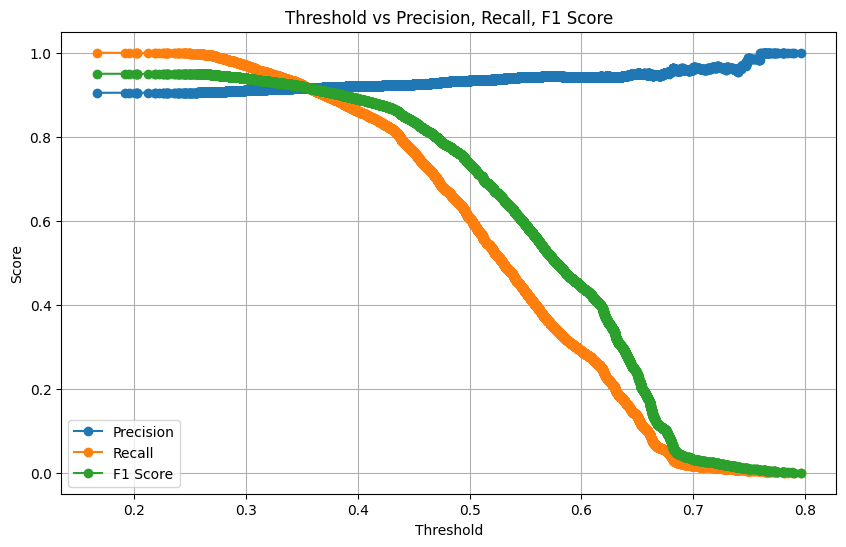

In [27]:
y_probs = model_xgb.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, y_probs)

# Calcular f1_score para cada umbral
f1_scores = [f1_score(y_val, y_probs >= threshold) for threshold in thresholds]

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], marker='o', label='Precision')
plt.plot(thresholds, recall[:-1], marker='o', label='Recall')
plt.plot(thresholds, f1_scores, marker='o', label='F1 Score')
plt.title('Threshold vs Precision, Recall, F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
X_train= train_set[features]
y_train= train_set[target]

X_val = val_set[features]
y_val = val_set[target]

X_test = test_set[features]
y_test = test_set[target]

y_pred_train = predict(model_xgb, X_train,0.35)
y_pred_val = predict(model_xgb, X_val,0.35)
y_pred_test = predict(model_xgb, X_test,0.35)

# Consolidar los resultados
results = consolidate_results(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test, 'rus', 'xgb') 
results

,tecnica_submuestreo,tecnica_ml,dataset,accuracy,precision,recall,specificity,f1_score,tn,fp,fn,tp
0,rus,xgb,Train,0.868742,0.924255,0.932502,0.207714,0.928360,2542,9696,8564,118313
1,rus,xgb,Validation,0.854103,0.915789,0.923649,0.194696,0.919702,323,1336,1201,14529
2,rus,xgb,Test,0.846176,0.914892,0.915067,0.193373,0.914979,321,1339,1336,14394


In [ ]:
muestra_train_val

## Interpretación del modelo

### SHAP Values

In [30]:
explainer = shap.Explainer(model_xgb)
shap_values = explainer.shap_values(X_train)

[11:57:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


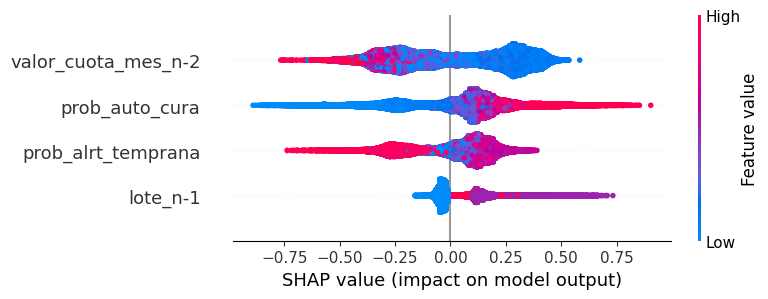

In [31]:
shap.summary_plot(shap_values , X_train )

In [32]:
# gráficos de cascada y dispersión
explainer = shap.Explainer(model_xgb, X_train)
shap_values = explainer(X_train)

[11:59:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
100%|===================| 139047/139115 [20:38<00:00]        

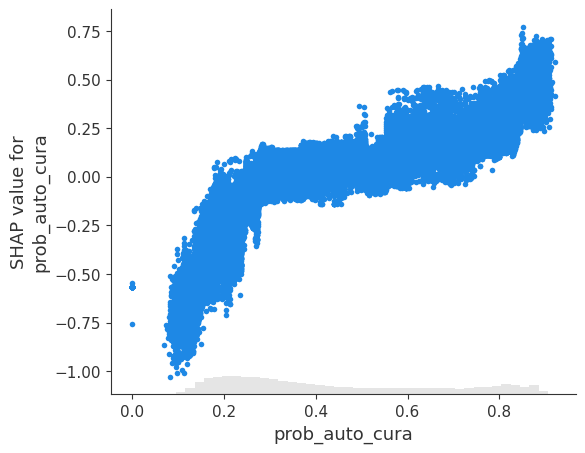

In [33]:
# Gráfico de dispersión de x variable 
shap.plots.scatter(shap_values[:, 'prob_auto_cura'])

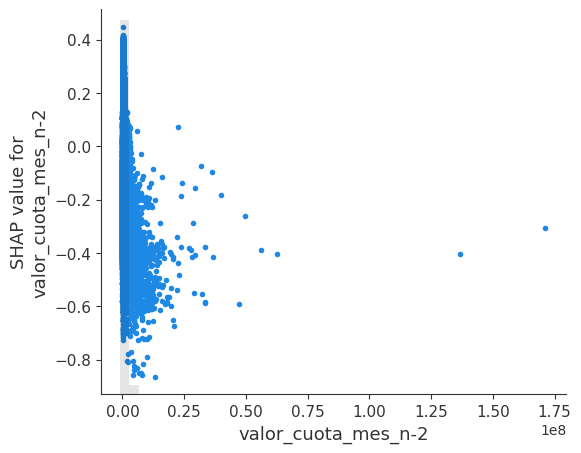

In [34]:
shap.plots.scatter(shap_values[:, 'valor_cuota_mes_n-2'])

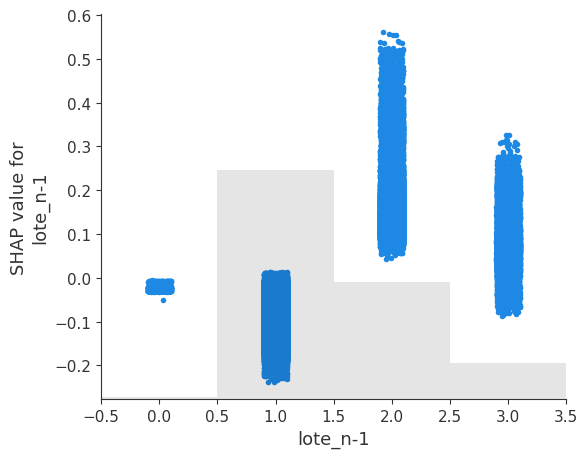

In [35]:
shap.plots.scatter(shap_values[:, 'lote_n-1'])

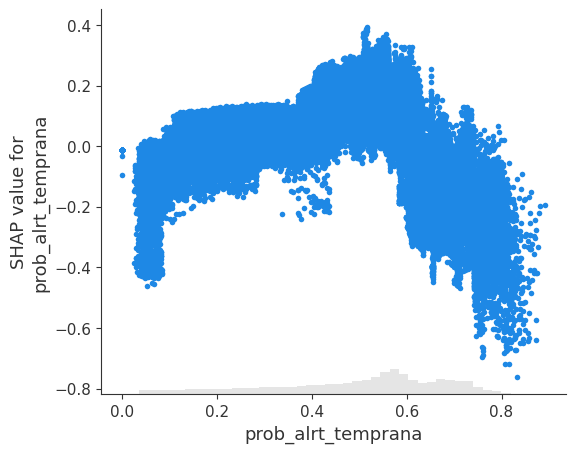

In [36]:
shap.plots.scatter(shap_values[:, 'prob_alrt_temprana'])

In [67]:
muestra_train_val[8:9]

,llave_modelo,llave_modelo3,fecha_corte,var_rpta_alt,lote,prob_propension,prob_alrt_temprana,prob_auto_cura,lote_n-1,prob_propension_n-1,...,porc_pago_n-4,diferencia_dias_n-4,valor_cuota_mes_n-5,pago_total_n-5,porc_pago_n-5,diferencia_dias_n-5,valor_cuota_mes_n-6,pago_total_n-6,porc_pago_n-6,diferencia_dias_n-6
24149,485380#856683#223659,485380#223659,202307,0,1.0,0.388445,0.757228,0.151278,1.0,0.670157,...,0.0,0.0,460550.0,921100.0,200.0,0.0,460550.0,921100.0,200.0,0.0


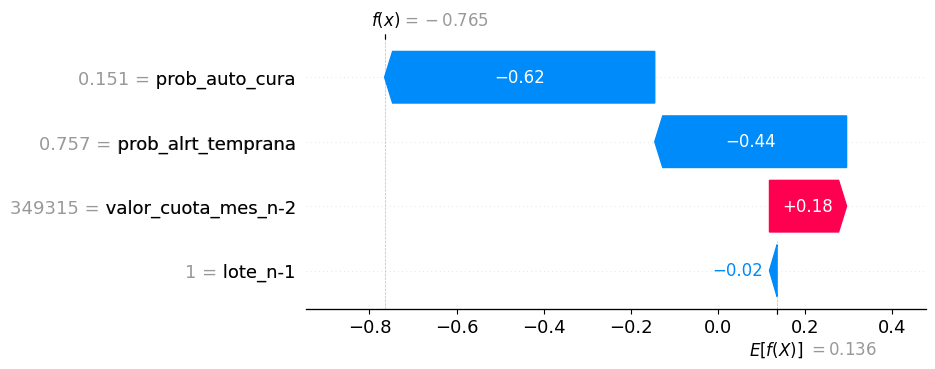

In [63]:
shap.plots.waterfall(shap_values[8], max_display=25)

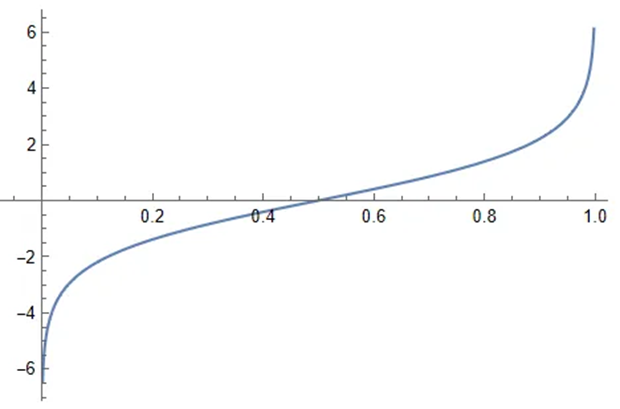

In [88]:
import math
numerator = math.exp(-0.765)
denominator = 1 + math.exp(-0.765)
result = numerator / denominator

print(result) 

0.3175616978069352


In [81]:
muestra_train_val[9:10]

,llave_modelo,llave_modelo3,fecha_corte,var_rpta_alt,lote,prob_propension,prob_alrt_temprana,prob_auto_cura,lote_n-1,prob_propension_n-1,...,porc_pago_n-4,diferencia_dias_n-4,valor_cuota_mes_n-5,pago_total_n-5,porc_pago_n-5,diferencia_dias_n-5,valor_cuota_mes_n-6,pago_total_n-6,porc_pago_n-6,diferencia_dias_n-6
24148,380968#742946#337396,380968#337396,202307,1,1.0,0.840545,0.075379,0.826236,1.0,0.848076,...,100.0,0.0,1834315.0,7337260.0,400.0,27.0,1834315.0,11005890.0,600.0,27.0


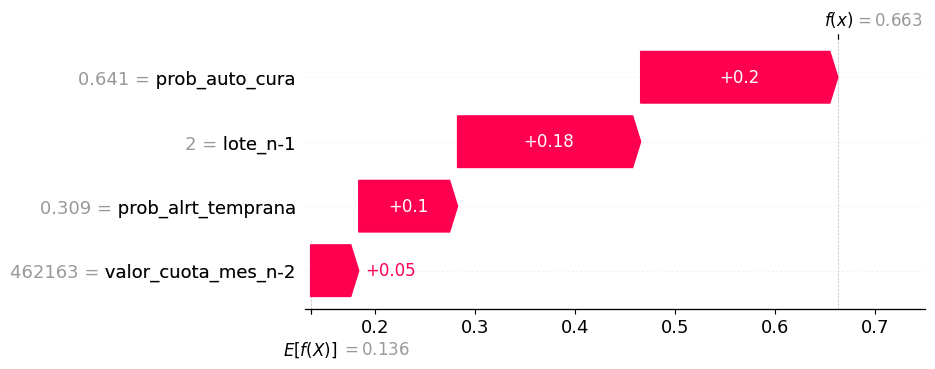

In [85]:
shap.plots.waterfall(shap_values[60], max_display=25)

In [89]:
import math
numerator = math.exp(0.663)
denominator = 1 + math.exp(0.663)
result = numerator / denominator

print(result) 

0.659933974505477


### PDPs and ICE Plots

In [91]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

,'prob_auto_cura'
,'valor_cuota_mes_n-2'
,'lote_n-1'
,'prob_alrt_temprana'

In [92]:
pdp_lines = partial_dependence(model_xgb, 
                               X_train, 
                               features='prob_auto_cura', 
                               grid_resolution=20, 
                               kind='individual')

len(pdp_lines['individual'][0])

139115

In [93]:
print(np.shape(pdp_lines['values']))
print(np.shape(pdp_lines['individual']))

(1, 20)
(1, 139115, 20)


Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.


In [95]:
X_train_pred = model_xgb.predict(X_train)

Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.


Text(0.5, 1.0, 'Partial Dependence Plot')

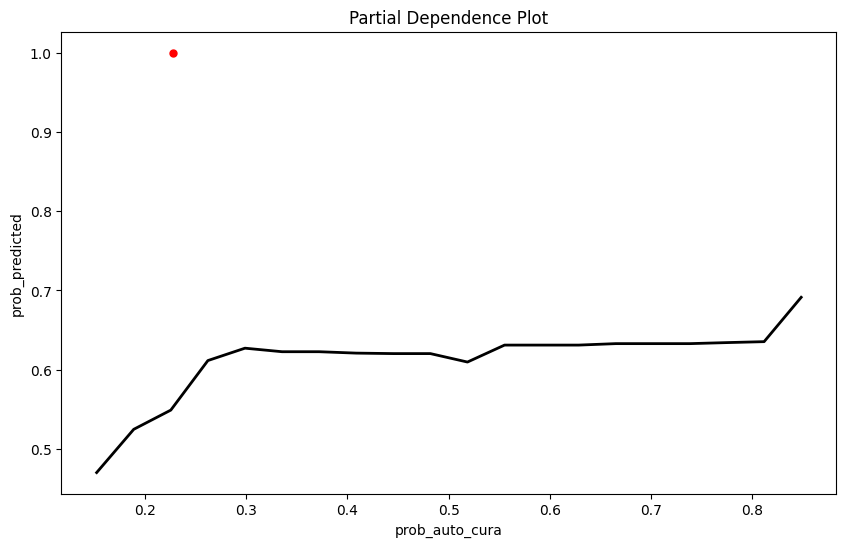

In [96]:
plt.figure(figsize=(10, 6))

plt.plot(pdp_lines['values'][0], pdp_lines['individual'][0][0], linewidth=2,color='black')

cliente_0 = X_train.iloc[0]
plt.plot(cliente_0['prob_auto_cura'], X_train_pred[0], 'ro', markersize=5)

plt.ylabel('prob_predicted')
plt.xlabel('prob_auto_cura')
plt.title('Partial Dependence Plot')

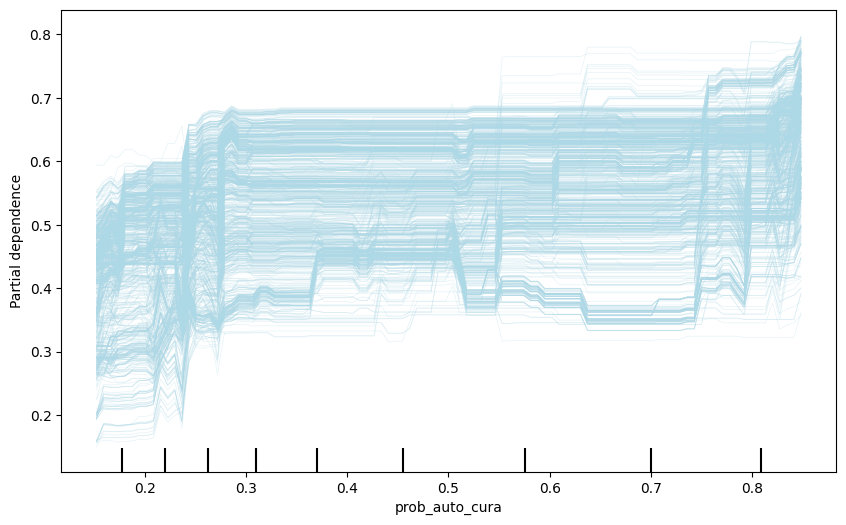

In [98]:
# ICE Plot
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10, 6))
PartialDependenceDisplay.from_estimator(model_xgb, 
                                        X_train,
                                          ['prob_auto_cura'],
                                            kind='individual',
                                            ice_lines_kw={'color':'lightblue', 'linewidth':0.5},
                                            ax=ax)

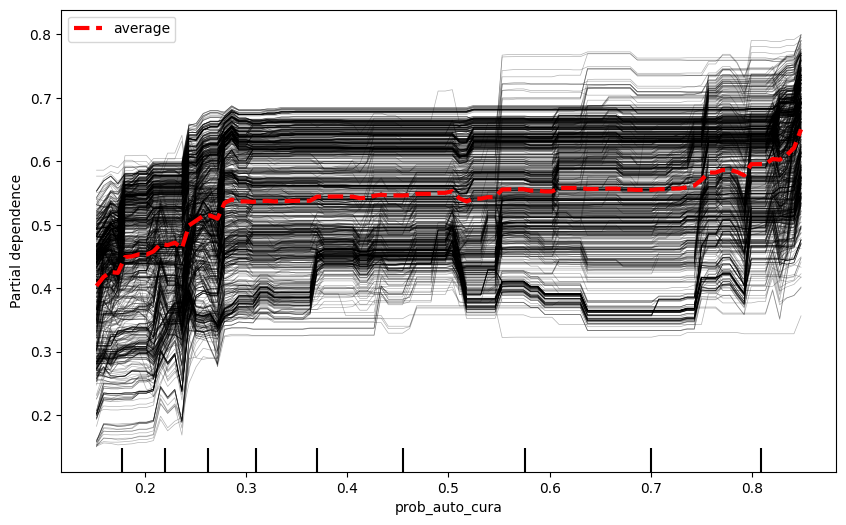

In [99]:
# ICE Plot
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10, 6))
PartialDependenceDisplay.from_estimator(model_xgb, 
                                        X_train,
                                          ['prob_auto_cura'],
                                            kind='both',
                                            ice_lines_kw={'color':'black'},
                                            pd_line_kw={'color':'red', "lw":3,'linestyle':'--'},
                                            ax=ax)

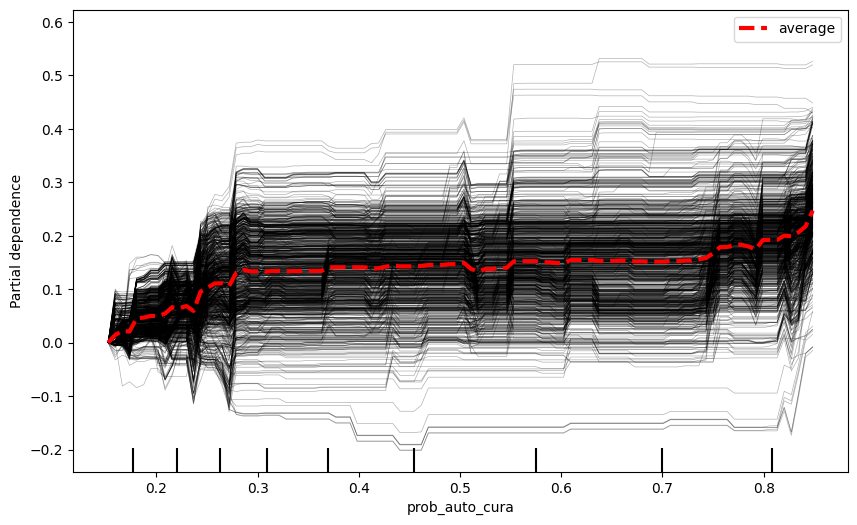

In [100]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10, 6))
PartialDependenceDisplay.from_estimator(model_xgb, 
                                        X_train,
                                          ['prob_auto_cura'],
                                            kind='both',
                                            centered=True,
                                            ice_lines_kw={'color':'black'},
                                            pd_line_kw={'color':'red', "lw":3,'linestyle':'--'},
                                            ax=ax)

In [102]:
df_train = pd.concat([X_train, y_train], axis=1)

In [112]:
pdp_lines = partial_dependence(model_xgb, 
                               X_train, 
                               features='valor_cuota_mes_n-2', 
                               percentiles=(0, 1),
                               grid_resolution=20,
                               kind='both')

for i in range (0,139115 ):
    pdp_start =pdp_lines['individual'][0][i][0]
    pdp_end = pdp_lines['individual'][0][i] = pdp_lines['individual'][0][i] - pdp_start

In [107]:
df_train.columns

Index(['prob_auto_cura', 'valor_cuota_mes_n-2', 'lote_n-1',
       'prob_alrt_temprana', 'var_rpta_alt'],
      dtype='object')

Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.


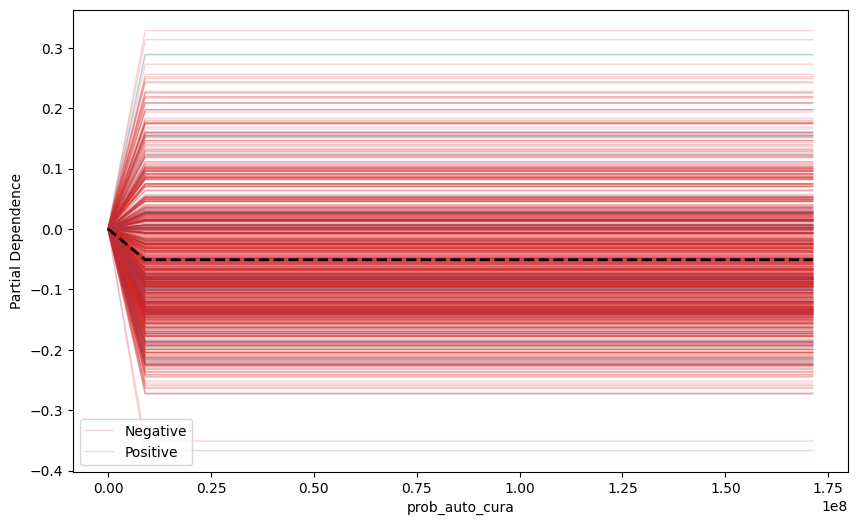

In [114]:
color_feature = 'var_rpta_alt'
colors =['tab:blue','tab:red']
plt.figure(figsize=(10, 6))

for i in range(0,1000):
    color = colors[df_train[color_feature].values[i]]
    plt.plot(pdp_lines['values'][0],
              pdp_lines['individual'][0][i], 
              linewidth=1, 
              color=color,
              alpha = 0.2)
    
pdp= pdp_lines['average'][0]- pdp_lines['average'][0][0]
plt.plot(pdp_lines['values'][0], pdp, linewidth=2, color='black',linestyle='--')

plt.ylabel('Partial Dependence')
plt.xlabel('prob_auto_cura')

plt.legend(['Negative','Positive'])

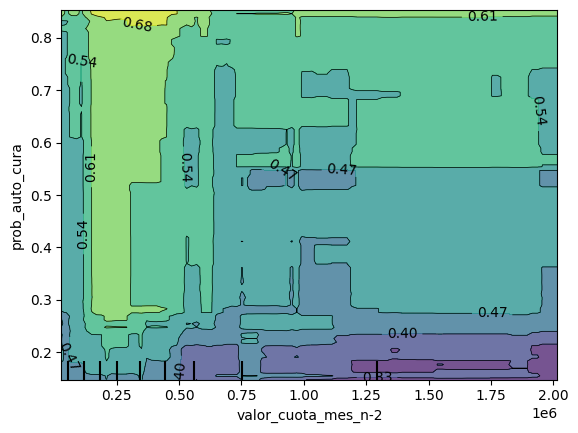

In [116]:
features = [("valor_cuota_mes_n-2","prob_auto_cura")]
PartialDependenceDisplay.from_estimator(model_xgb,X_train[0:1000],features)

In [123]:
muestra_train_val.head()

,llave_modelo,llave_modelo3,fecha_corte,var_rpta_alt,lote,prob_propension,prob_alrt_temprana,prob_auto_cura,lote_n-1,prob_propension_n-1,...,porc_pago_n-4,diferencia_dias_n-4,valor_cuota_mes_n-5,pago_total_n-5,porc_pago_n-5,diferencia_dias_n-5,valor_cuota_mes_n-6,pago_total_n-6,porc_pago_n-6,diferencia_dias_n-6
0,630611#219718#863073,630611#863073,202307,1,1.0,0.654196,0.487352,0.227337,1.0,0.611498,...,0.0,0.0,496815.0,0.0,0.0,0.0,538113.0,1614342.0,300.0,0.0
24156,485162#197307#890953,485162#890953,202307,1,3.0,0.737191,0.288896,0.663719,3.0,0.837386,...,118.0,0.0,17594.0,0.0,0.0,0.0,18647.0,18647.0,100.0,0.0
24155,615264#391620#688287,615264#688287,202307,0,2.0,0.837814,0.071897,0.876519,2.0,0.850098,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24154,347037#627141#453201,347037#453201,202307,1,2.0,0.786104,0.131714,0.684485,2.0,0.788930,...,100.0,0.0,103329.0,206658.0,200.0,0.0,103329.0,619974.0,600.0,19.0
24153,33153#701422#378920,33153#378920,202307,1,1.0,0.864944,0.289644,0.758346,1.0,0.843537,...,200.0,0.0,371464.0,743000.0,200.0,0.0,371464.0,1114500.0,300.0,0.0


In [125]:
df_val_streamlit=muestra_train_val[[
    'llave_modelo'
    ,'prob_auto_cura'
,'valor_cuota_mes_n-2'
,'lote_n-1'
,'prob_alrt_temprana'
, 'var_rpta_alt'
    
]].head(17389)



In [156]:
df_val_streamlit=muestra_train_val[[
    'llave_modelo'
    ,'prob_auto_cura'
,'valor_cuota_mes_n-2'
,'lote_n-1'
,'prob_alrt_temprana'
, 'var_rpta_alt'
    
]].head(17389)

In [157]:
df_val_to_predict = df_val_streamlit[['prob_auto_cura'
,'valor_cuota_mes_n-2'
,'lote_n-1'
,'prob_alrt_temprana']]

df_val_predict = predict(model_xgb, df_val_to_predict,0.35)


In [158]:
pred_df = pd.DataFrame(df_val_predict, columns=['pred'])

In [159]:
df_val_streamlit = pd.concat([df_val_streamlit.reset_index(drop=True), pred_df.reset_index(drop=True)], axis=1)

In [160]:
df_val_streamlit.head(20)

,llave_modelo,prob_auto_cura,valor_cuota_mes_n-2,lote_n-1,prob_alrt_temprana,var_rpta_alt,pred
0,630611#219718#863073,0.227337,433581.0,1.0,0.487352,1,1
1,485162#197307#890953,0.663719,6714.0,3.0,0.288896,1,1
2,615264#391620#688287,0.876519,0.0,2.0,0.071897,0,1
3,347037#627141#453201,0.684485,103329.0,2.0,0.131714,1,1
4,33153#701422#378920,0.758346,371902.0,1.0,0.289644,1,1
5,66500#313786#769352,0.140988,709340.0,1.0,0.593300,1,1
6,161744#1057704#22638,0.467436,526726.0,1.0,0.666670,1,1
7,413775#982633#97709,0.877969,650510.0,1.0,0.240886,1,1
8,485380#856683#223659,0.151278,349315.0,1.0,0.757228,0,0
9,380968#742946#337396,0.826236,1834315.0,1.0,0.075379,1,0


In [161]:
df_val_streamlit.to_parquet('df_val_streamlit.parquet', index=False)

## Construcción de tabla de Punteo

In [162]:
df_ids_oot = pd.read_csv('prueba_op_base_pivot_var_rpta_alt_enmascarado_oot.csv')
df_ids_oot["llave_modelo"] = df_ids_oot["nit_enmascarado"].astype(str) + \
                                                    "#" + df_ids_oot["num_oblig_orig_enmascarado"].astype(str) + \
                                                    "#" + df_ids_oot["num_oblig_enmascarado"].astype(str)
df_ids_oot["llave_modelo_2"] = df_ids_oot["nit_enmascarado"].astype(str) + \
                                                    "#" + df_ids_oot["num_oblig_enmascarado"].astype(str)
df_ids_oot["fecha_corte"] = 202312


df_ids_oot.head()

,nit_enmascarado,num_oblig_orig_enmascarado,num_oblig_enmascarado,fecha_var_rpta_alt,llave_modelo,llave_modelo_2,fecha_corte
0,257335,444821,635511,202401,257335#444821#635511,257335#635511,202312
1,59584,350400,730364,202401,59584#350400#730364,59584#730364,202312
2,397604,973821,106521,202401,397604#973821#106521,397604#106521,202312
3,368086,382995,696856,202401,368086#382995#696856,368086#696856,202312
4,255009,434238,645924,202401,255009#434238#645924,255009#645924,202312


In [163]:
merged_df_v1= pd.merge(df_ids_oot, 
                     df_var_prob_mod_cobranza_v1, 
                     left_on=['llave_modelo_2', 'fecha_corte'], 
                     right_on=['llave_modelo_2', 'fecha_corte'], 
                     how='left')  # Puedes cambiar el tipo de unión a 'left', 'right' o 'outer' si es necesario

# Mostrar las primeras filas del DataFrame resultante
merged_df_v1.head()

,nit_enmascarado,num_oblig_orig_enmascarado,num_oblig_enmascarado,fecha_var_rpta_alt,llave_modelo,llave_modelo_2,fecha_corte,lote,prob_propension,prob_alrt_temprana,...,prob_alrt_temprana_n-4,prob_auto_cura_n-4,lote_n-5,prob_propension_n-5,prob_alrt_temprana_n-5,prob_auto_cura_n-5,lote_n-6,prob_propension_n-6,prob_alrt_temprana_n-6,prob_auto_cura_n-6
0,257335,444821,635511,202401,257335#444821#635511,257335#635511,202312,1.0,0.733536,0.424859,...,0.327832,0.771047,1.0,0.790664,0.466034,0.545282,1.0,0.780205,0.361285,0.689167
1,59584,350400,730364,202401,59584#350400#730364,59584#730364,202312,2.0,0.741083,0.203964,...,0.154385,0.794606,2.0,0.820647,0.125408,0.827273,2.0,0.791695,0.125364,0.729285
2,397604,973821,106521,202401,397604#973821#106521,397604#106521,202312,1.0,0.250561,0.715489,...,0.319392,0.845383,1.0,0.841541,0.106415,0.812327,1.0,0.839025,0.122032,0.803535
3,368086,382995,696856,202401,368086#382995#696856,368086#696856,202312,1.0,0.742705,0.491246,...,0.366539,0.597241,1.0,0.839129,0.238351,0.860538,2.0,0.805095,0.342535,0.872748
4,255009,434238,645924,202401,255009#434238#645924,255009#645924,202312,3.0,0.291181,0.597897,...,0.584584,0.113752,3.0,0.395668,0.594532,0.215063,3.0,0.292125,0.588536,0.153101


In [164]:
merged_df_v2_punteo= pd.merge(merged_df_v1, 
                     df_comportamieto_pagos, 
                     left_on=['llave_modelo_2', 'fecha_corte'], 
                     right_on=['llave_modelo_2', 'fecha_corte'], 
                     how='left')  # Puedes cambiar el tipo de unión a 'left', 'right' o 'outer' si es necesario

# Mostrar las primeras filas del DataFrame resultante
merged_df_v2_punteo.head()

,nit_enmascarado,num_oblig_orig_enmascarado,num_oblig_enmascarado,fecha_var_rpta_alt,llave_modelo,llave_modelo_2,fecha_corte,lote,prob_propension,prob_alrt_temprana,...,porc_pago_n-4,diferencia_dias_n-4,valor_cuota_mes_n-5,pago_total_n-5,porc_pago_n-5,diferencia_dias_n-5,valor_cuota_mes_n-6,pago_total_n-6,porc_pago_n-6,diferencia_dias_n-6
0,257335,444821,635511,202401,257335#444821#635511,257335#635511,202312,1.0,0.733536,0.424859,...,200.0,0.0,614989.0,1229978.0,200.0,0.0,763353.0,0.0,0.0,0.0
1,59584,350400,730364,202401,59584#350400#730364,59584#730364,202312,2.0,0.741083,0.203964,...,200.0,0.0,382420.0,1147261.0,300.0,0.0,243747.0,974990.0,400.0,2.0
2,397604,973821,106521,202401,397604#973821#106521,397604#106521,202312,1.0,0.250561,0.715489,...,110.0,0.0,376643.0,352000.0,93.0,0.0,364762.0,364762.0,100.0,0.0
3,368086,382995,696856,202401,368086#382995#696856,368086#696856,202312,1.0,0.742705,0.491246,...,54.0,0.0,170745.0,337280.0,198.0,0.0,427475.0,34597.0,8.0,15.0
4,255009,434238,645924,202401,255009#434238#645924,255009#645924,202312,3.0,0.291181,0.597897,...,0.0,0.0,204650.0,183817.0,90.0,0.0,153883.0,0.0,0.0,0.0


In [165]:
base_punteo_df= merged_df_v2_punteo[[
'llave_modelo'
,'llave_modelo_2'
,'fecha_var_rpta_alt'

,'prob_auto_cura'
,'valor_cuota_mes_n-2'
,'lote_n-1'
,'prob_alrt_temprana'
]]

base_punteo_df.head()

,llave_modelo,llave_modelo_2,fecha_var_rpta_alt,prob_auto_cura,valor_cuota_mes_n-2,lote_n-1,prob_alrt_temprana
0,257335#444821#635511,257335#635511,202401,0.697358,682842.0,1.0,0.424859
1,59584#350400#730364,59584#730364,202401,0.787728,376534.0,2.0,0.203964
2,397604#973821#106521,397604#106521,202401,0.313812,1440680.0,1.0,0.715489
3,368086#382995#696856,368086#696856,202401,0.372921,141993.0,1.0,0.491246
4,255009#434238#645924,255009#645924,202401,0.299553,167598.0,3.0,0.597897


In [166]:
base_punteo_df=base_punteo_df.fillna(0)

In [167]:
X_oot = base_punteo_df[[ 'prob_auto_cura'
,'valor_cuota_mes_n-2'
,'lote_n-1'
,'prob_alrt_temprana']]

In [169]:
y_oot= predict(model_xgb, X_oot, threshold=0.35)

In [170]:
oot_ids = base_punteo_df[['llave_modelo']]
oot_ids['var_rpta_alt'] = y_oot
oot_ids.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,llave_modelo,var_rpta_alt
0,257335#444821#635511,1
1,59584#350400#730364,1
2,397604#973821#106521,1
3,368086#382995#696856,1
4,255009#434238#645924,1


In [171]:
oot_ids = oot_ids.rename(columns={'llave_modelo': 'ID'})
oot_ids.to_csv('oot_ids_submit3.csv', index=False)